# POS Tagging
Part-of Speech (POS) tagging as Sequence Labelling using Recurrent Neural Architectures performed on the "Dependency Treebank" dataset.

# Libraries import

In [1]:
!pip install gensim
!pip install keras-tuner

In [2]:
# system packages
import os
import shutil
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
from functools import partial

from tqdm import tqdm

from typing import List, Callable, Dict, Tuple
import urllib.request  #  download files
import zipfile

from collections import OrderedDict
import re
import nltk
import pickle



import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
import keras_tuner as kt

from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


import gensim
import gensim.downloader as gloader

C:\Users\Nicola\anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# I define a fixed seed, this way it is possible to reproduce the results

def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    

SEED = 42

set_reproducibility(SEED)

# Prerequisites - Database download and extraction
First of all we are going to download and extract the "Dependecy Treebank" database from NLTK, to do that we are going to define some specific function.


In [4]:
!rm -rf Datasets

"rm" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [5]:
def download_dataset(download_path: str, url: str):
  """
  Utility function that allows to download a dataset given a specific url

  param: download_path: path where the resource will be downloaded
  param: url: the url where the resource can be found
  """
  if not os.path.exists(download_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, download_path)
    print("Download complete!")

def extract_dataset(download_path: str, extract_path: str):
    """
      Utility function that allows to extract a dataset

      param: download_path: path where the resource is stored
      param: extract_path: path where the resource will be extracted
    """
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(dataset_path,"r") as zip_ref:
      zip_ref.extractall(dataset_folder)
    print("Extraction completed!")

In [6]:
dataset_name = "dependency_treebank"
dataset_folder = os.path.join(os.getcwd(), "Datasets")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'
dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")


download_dataset(dataset_path, url)
extract_dataset(dataset_path, dataset_folder)

Extracting dataset... (it may take a while...)
Extraction completed!


# Data preparation
In this section we are going to prepare the data, in order we will encode the data, then explore them and finally we'll build the vocabularies.

## Dataset encoding
For the dataset encoding we decided to split the documents into sentences. We decided to split documents into sentences because in a sequence labeling task like this one, the grammatical analysis for the tag assignment must focus on single sentences and not on the full document.
<br> In the following subsection we are going to define the necessary function to perform the encoding, but first of all we define some constants we will use in this project. <br>

For the encoding of the dataset we decided to introduce the boolean variable *to_lowercase*, which if set to True puts all words to lower case.  

In [7]:
#Constant Definition

COLUMN_DOCUMENT_ID = 'doc_id'
COLUMN_SENTENCE_ID = 'sentence_id'
COLUMN_WORDS = 'words'
COLUMN_TAGS = 'tags'
COLUMN_WORDS_INDEXED = 'indexed_words'
COLUMN_TAGS_INDEXED = 'indexed_tags'


MODEL_TYPE  =  'model_type'
BASELINE = 'baseline'
GRU = 'gru'
DOUBLE_LSTM = 'double_lstm'
DOUBLE_FC = 'double_fc'


# Keys of the dictionary
LEARNING_RATE = 'lr'
OPTIMIZER = 'optim'
BATCH_SIZE = 'batch_size'
VAL_ACCURACY = 'val_accuracy'

LSTM_UNITS = 'lstm_units'
GRU_UNITS = 'gru_units'
SECOND_LSTM_UNITS = 'second_lstm_units'
FC_UNITS = 'fc_units'
FC_ACTIVATIONS = 'fc_activ'

In [8]:
def encode_document(doc_path: str, to_lowercase:bool) -> List[Dict]:
  """
  The function allows to encode all the information of a single document,
  splitting it into sentences, identified by document id and a sentence id.

  :param doc_path: path of the document which has to be encoded
  :param to_lowercase: boolean which is used to decide whether or not to conver the whole text to lowercase

  :return document_rows: a list of vocabularies containing, for each sentence of the document
        the following information:
          - document_id: identifier for the document
          - sentence_id: identifier for the sentence in the document
          - words: list containing all the tokens in the sentence
          - tags: list containing all the tags for the tokens of the sentence
  """
  doc = os.path.basename(doc_path)
  document_rows = [] # list which will contain all the rows for the document we are currently parsing
  doc_id = int(re.findall(r'\d+', doc)[0]) # finds the number of the document

  with open(doc_path, mode='r', encoding='utf-8') as text_file:
    text = text_file.read()
    text = text.split("\n\n") # A new sentence is identified by two \n characters

    sentence_id = 0 # unique id for the sentence in the document

    for sentence in text:
      sentence_id += 1

      words_array = [] 
      tags_array = []

      lines = sentence.split("\n")

      for line in lines:
        data = line.split('\t') # data contains information on both the word and the POS tag

        if line != '':

          if to_lowercase:
            data[0] = data[0].lower()

          words_array.append(data[0])
          tags_array.append(data[1])

      # Once extracted all the information about the sentence in the document, I build the entry for the dataframe
      dataframe_entry = {
            COLUMN_DOCUMENT_ID: doc_id,
            COLUMN_SENTENCE_ID: sentence_id,
            COLUMN_WORDS: words_array,
            COLUMN_TAGS: tags_array
        }

      document_rows.append(dataframe_entry)

  return document_rows


def encode_dataset(dataset_name: str, to_lowercase: bool = False) -> pd.DataFrame:
  """
    The function allows us to encode the dataset we will use for the assignment

    :param dataset_name: String representing the name of the dataset
    :param to_lowercase: Boolean value representing whether or not to convert the whole text to lowercase

    :return df: dataframe which contains all the sentences of the documents, sorted by document id.
  """
  dataframe_rows = []
  dataset_folder = os.path.join(os.getcwd(), "Datasets", dataset_name)

  for doc in os.listdir(dataset_folder):
    doc_path = os.path.join(dataset_folder,doc)

    try:
      document_sentences = encode_document(doc_path, to_lowercase)
      for sentence in document_sentences:
        dataframe_rows.append(sentence)

    except Exception as e:
      print('Failed to process %s. Reason: %s' % (doc_path, e))
      sys.exit(0)

  # transform the list of rows in a proper dataframe
  df = pd.DataFrame(dataframe_rows)
  df = df[["doc_id", "sentence_id", "words", "tags"]]


  # Serialization of the dataframe into a pickle file
  folder = os.path.join(os.getcwd(), "Datasets", "Dataframes", dataset_name)
  if not os.path.exists(folder):
    os.makedirs(folder)	     

  dataframe_path = os.path.join(folder, dataset_name + ".pkl")
  df.to_pickle(dataframe_path)

  return df.sort_values(['doc_id', 'sentence_id'])

In [9]:
print("Encoding dataset...")
df= encode_dataset(dataset_name, to_lowercase=True)
print("Encoding completed!")

print(f"Dataset size: {df.shape}")
print(f"Some examples:")
df.head()

Encoding dataset...
Encoding completed!
Dataset size: (3914, 4)
Some examples:


,doc_id,sentence_id,words,tags
0,1,1,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,1,2,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,2,1,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,3,1,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,3,2,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."


## Data exploration
In this subsection we are going to explore our data in order to learn some information like the most frequent words and tags.

In [10]:
def get_unique_words(df: pd.DataFrame)-> List[str]:
    """
      The function allows to retrieve all the unique words in our dataframe
      and return them in a sorted List

      :param df: the dataframe from which we want to get all the unique words

      :return words_listing: a list of string containing all the unique words

    """
    words_listing = set()
    sentences_list = df[COLUMN_WORDS].values.tolist()

    for sentence in sentences_list: 
      words_listing.update(sentence)

    return sorted(list(words_listing))

def get_unique_tags(df: pd.DataFrame)-> List[str]:
    """
  The function allows to retrieve all the unique tags in our dataframe
  and return them in a sorted List

  :param df: the dataframe from which we want to get all the unique tags

  :return tags_listing: a list of string containing all the unique tags

    """
    tags_listing = set()
    tags_list = df[COLUMN_TAGS].values.tolist()
    
    for tags in tags_list: 
      tags_listing.update(tags)

    return sorted(list(tags_listing))

In [11]:
words_listing = get_unique_words(df)
tags_listing = get_unique_tags(df)
print('Unique words: ', len(words_listing))
print('Unique tags: ', len(tags_listing))

Unique words:  10947
Unique tags:  45


Here we are going to compute the top 10 most frequent tags and words.

In [12]:
tags_fd = nltk.probability.FreqDist(itertools.chain(*df[COLUMN_TAGS].values.tolist()))
most_common_tags = tags_fd.most_common(10)

words_fd = nltk.probability.FreqDist(itertools.chain(*df[COLUMN_WORDS].values.tolist()))
most_common_words = words_fd.most_common(10)

print('Top 10 most common tags: ', most_common_tags)
print('Top 10 most common words: ', most_common_words)


Top 10 most common tags:  [('NN', 13166), ('IN', 9857), ('NNP', 9410), ('DT', 8165), ('NNS', 6047), ('JJ', 5834), (',', 4886), ('.', 3874), ('CD', 3546), ('VBD', 3043)]
Top 10 most common words:  [(',', 4885), ('the', 4764), ('.', 3828), ('of', 2325), ('to', 2182), ('a', 1988), ('in', 1769), ('and', 1556), ("'s", 865), ('for', 853)]


Now we are going to plot the ditribution of all the tags that are present in the dataframe and then the distribution of the 50 most frequent words.



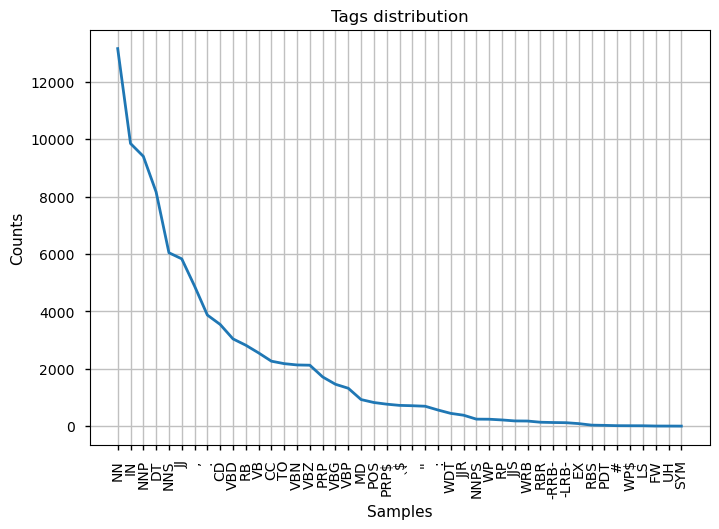

<AxesSubplot:title={'center':'Tags distribution'}, xlabel='Samples', ylabel='Counts'>

In [13]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-notebook')


tags_fd.plot(title="Tags distribution")

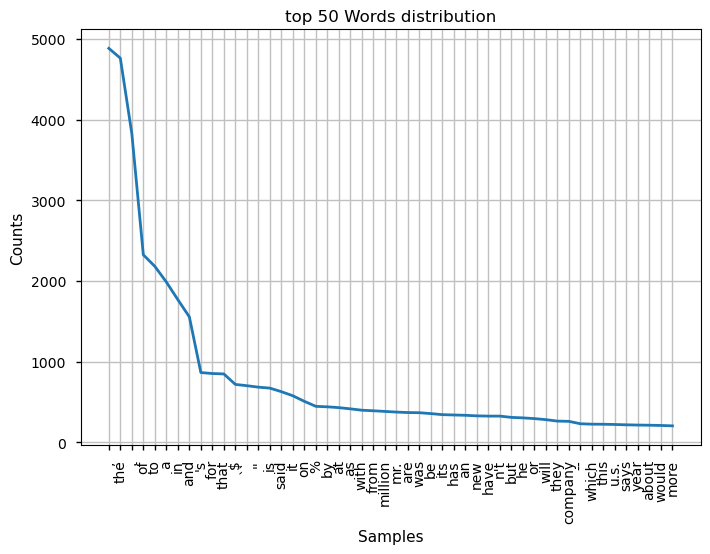

<AxesSubplot:title={'center':'top 50 Words distribution'}, xlabel='Samples', ylabel='Counts'>

In [14]:
words_fd.plot(50, title="top 50 Words distribution")

## Building the vocabularies

In this subsection we are going to build the vocabularies that will be used for the generation of the embedding matrix. We will generate two pairs of vocabularies which allow us to map both words and tags to their index.

In [15]:
#Constant Definition
PADDING_TOKEN_VAL = 0
PADDING_TOKEN_STRING = '0'

In [16]:
def build_vocabulary(strings : List[str]) -> Tuple[Dict[int, str], Dict[str, int]]:                                               
    """
    Function that allow us to build a vocabulary given a list of string

    param: strings: a list of strings

    return:
      - idx_to_str: vocabulary index to word
      - str_to_idx : vocabulary word to index
    """
    
    idx_to_str = OrderedDict()
    str_to_idx = OrderedDict()
    strings = sorted(strings)
    
    idx_to_str[0] = PADDING_TOKEN_STRING
    str_to_idx[PADDING_TOKEN_STRING] = PADDING_TOKEN_VAL

    for i, word in enumerate(strings):                
        idx_to_str[i+1] = word
        str_to_idx[word] = i+1 
    
    return idx_to_str, str_to_idx
                                 

We need to check that we can use 0 as padding token. In order to do this, we have to be sure that it doesn't appear in our lists of unique words and tags.

In [17]:
if PADDING_TOKEN_STRING in words_listing or PADDING_TOKEN_VAL in tags_listing:
  print(f'we can\'t use {PADDING_TOKEN_VAL} as padding token value or we can\'t use {PADDING_TOKEN_STRING} as padding token tag ')
else:
  print(f'we can use {PADDING_TOKEN_VAL} as padding token value or we can use "{PADDING_TOKEN_STRING}" as padding token tag ')


we can use 0 as padding token value or we can use "0" as padding token tag 


In [18]:
idx_to_word, word_to_idx = build_vocabulary(words_listing)
idx_to_tag,tag_to_idx = build_vocabulary(tags_listing)

Now we can update our dataframe and extend it with the indexed columns (The lists of indexes of each word and each tag).

In [19]:
def extend_dataframe_with_index( df: pd.DataFrame, word_to_idx: Dict[str, int], tag_to_idx: Dict[str, int]) -> pd.DataFrame:
    """
    The function allows to add columns to the dataframe, adding the column of
    the indexed words and the column of the indexed tag. 
    
    The two columns are added  according to the values of the previously created dictionaries.
    
    :param df: DataFrame that has to be extended
    :param word_to_idx: Dictionary containing words as keys and their index as value
    :param tag_to_idx: Dictionary containing tags as keys and their index as value
    
    :return df: Extended dataframe
    """
    column_words_indexed = []
    column_tags_indexed = []

    for words,tags in zip(df[COLUMN_WORDS],df[COLUMN_TAGS]):
        column_words_indexed.append([word_to_idx[word] for word in words ])
        column_tags_indexed.append([tag_to_idx[tag] for tag in tags ])

    df[COLUMN_WORDS_INDEXED] = column_words_indexed
    df[COLUMN_TAGS_INDEXED] = column_tags_indexed

    return df

In [20]:
df = extend_dataframe_with_index(df,word_to_idx, tag_to_idx )
print(f"Dataset size: {df.shape}") 
df.head()

Dataset size: (3914, 6)


,doc_id,sentence_id,words,tags,indexed_words,indexed_tags
0,1,1,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...","[7545, 10540, 20, 822, 10902, 7113, 20, 10776,...","[21, 21, 4, 10, 23, 15, 4, 19, 35, 11, 20, 14,..."
1,1,2,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...","[6738, 10540, 5659, 2445, 7078, 3936, 6791, 20...","[21, 21, 40, 20, 14, 21, 21, 4, 11, 21, 37, 20..."
2,2,1,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...","[8678, 1239, 20, 771, 10902, 7113, 1377, 4590,...","[21, 21, 4, 10, 23, 15, 9, 15, 20, 14, 21, 21,..."
3,3,1,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...","[1028, 4584, 7078, 1553, 7129, 10436, 10046, 6...","[11, 20, 14, 20, 28, 38, 33, 35, 21, 20, 23, 4..."
4,3,2,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...","[9949, 1553, 4420, 20, 3142, 20, 5659, 10403, ...","[11, 20, 20, 4, 20, 4, 40, 28, 15, 14, 26, 40,..."


Once we extended our dataframe we can finally split it into training, validation and test set. The dataset will be divided as follows:
* The training set will contain all the sentences of the documents from 1 to 100
* The validation set will contain the sentences of the documents from 101 to 150
* The test set will contain all the sentences of the documents from 151 to the last one (document 199)

In [21]:
def split_dataframe(df : pd.DataFrame, val_num : int, test_num : int) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
  """
  Splits a dataframe into training, validation and test set.

  :param df: Pandas DataFrame to be splitted
  :param val_num: Number of documents which will be part of the validation set
  :param test_num: Number of documents which will be in the test set.

  :return:
    - df_train: Pandas DataFrame containing all the documents of the training set
    - df_val: Pandas DataFrame containing all the documents of the validation set
    - df_test: Pandas DataFrame containing all the documents of the test set

  """
  len_doc = df[COLUMN_DOCUMENT_ID].nunique()

  df_train = None
  df_test = None
  df_val = None
  train_num = len_doc - test_num - val_num

  df_train = df.loc[df[COLUMN_DOCUMENT_ID].isin(range(train_num + 1))]
  df_val = df.loc[df[COLUMN_DOCUMENT_ID].isin(range(train_num + 1, train_num + val_num + 1))]
  df_test = df.loc[df[COLUMN_DOCUMENT_ID].isin(range(train_num + val_num + 1, len_doc + 1))]

  return (df_train, df_val, df_test)

In [22]:
df_train, df_val, df_test = split_dataframe(df, val_num=50, test_num=49 )
print('Length of training dataset: ', len(df_train))
print('Length of validation dataset: ', len(df_val))
print('Length of testing dataset: ', len(df_test))

Length of training dataset:  1963
Length of validation dataset:  1299
Length of testing dataset:  652


# Word Embeddings - GloVe

In this section we are going to perform the word embeddings: we will use GloVe pre-trained embeddings with a fixed dimensionality of 50.

In [23]:
def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
 
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [24]:
EMBEDDING_DIMENSION = 50
embedding_model = load_embedding_model(embedding_dimension=EMBEDDING_DIMENSION)

Now that we have the GloVe embeddings we can check if there are any Out of Vocabulary words (OOV). We consider a word as OOV if it is present in our set but not in the GloVe embeddings.

In [25]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [26]:
total_oov_terms = check_OOV_terms(embedding_model, words_listing)
total_oov_percentage = float(len(total_oov_terms)) * 100 / len(words_listing)

train_unique_words = get_unique_words(df_train)
train_oov_terms = check_OOV_terms(embedding_model, train_unique_words)
train_oov_percentage = float(len(train_oov_terms)) * 100 / len(train_unique_words)

val_unique_words = get_unique_words(df_val)
val_oov_terms = check_OOV_terms(embedding_model, val_unique_words)
val_oov_percentage = float(len(val_oov_terms)) * 100 / len(val_unique_words)

test_unique_words = get_unique_words(df_test)
test_oov_terms = check_OOV_terms(embedding_model, test_unique_words)
test_oov_percentage = float(len(test_oov_terms)) * 100 / len(test_unique_words)


print(f"Total OOV terms: {len(total_oov_terms)} ({total_oov_percentage:.2f}%)")
print(f"Training set OOV terms: {len(train_oov_terms)} ({train_oov_percentage:.2f}%)")
print(f"Validion set OOV terms: {len(val_oov_terms)} ({val_oov_percentage:.2f}%)")
print(f"Test set OOV terms: {len(test_oov_terms)} ({test_oov_percentage:.2f}%)")

Total OOV terms: 676 (6.18%)
Training set OOV terms: 359 (4.85%)
Validion set OOV terms: 213 (3.93%)
Test set OOV terms: 161 (4.73%)


We now define the functions used to build and update the embedding matrix. We decided to create a function which allows to compute the embedding vector, which is used only for the OOV terms. It is possible to compute the embedding vector in 3 static ways:
* Using a random vector;
* Using a fixed placeholder
* Computing the mean of the neighbors of the single term

In [27]:
def compute_embedding_vector(word : str, 
                             mode : str, 
                             embedding_model : gensim.models.keyedvectors.KeyedVectors,
                             placeholder : float = 0.,
                             neighbors=None):
    """
    The function allows to compute the embedding vector of a given word in one of 3 different modalities: placeholder, random
    or mean. 
    
    :param word: word of which we want to compute the embedding vector
    :param mode: modality in which the embedding vector will be computed
    :param embedding_model: embedding model
    :param placeholder: (optional) represents the value for the placeholder. Default to 0
    :param neighbors: list of words which are close to the target word, it is used only in case of mean as modality.
    
    :return word_vector: Embedding of the word.
    
    """
    
    
    word_vector = []
    if mode == 'random':
        word_vector = np.random.uniform(low=-0.05, high=0.05, size=EMBEDDING_DIMENSION)

    elif mode == 'placeholder':
        word_vector = [placeholder] * EMBEDDING_DIMENSION

    elif mode == 'mean': 
        #take neighbors for the specified word
        neighborhood = neighbors[word]
        not_oov_neighbors = []

        #check if there is any OOV between the neighbors
        for n in neighborhood:
            if n in embedding_model.vocab.keys():
              not_oov_neighbors.append(embedding_model[n])

        # If there is at least one neighbor compute the mean of their word vectorsm,
        # Otherwise, use random mode
        if len(not_oov_neighbors) > 0:
          word_vector = np.mean(not_oov_neighbors, axis=0)
        else:
          word_vector = np.random.uniform(low=-0.05, high=0.05, size=EMBEDDING_DIMENSION)
    
    return word_vector
      


def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           word_to_idx: Dict[str, int],
                           unique_words: List[str],
                           oov_terms: List[str],
                           mode = 'random',
                           placeholder = 0.5,
                           neighbors = None) -> np.ndarray:
    """
    The function allows to build the embedding matrix, given an embedding model and the list of unique words.
    
    :param embedding_model: embedding model
    :param word_to_idx: Dictionary containing all the mappings between words and indexed
    :param unique_words: list of unique words
    :param mode: mode in which the embedding for the OOV words will be computed. One of 'random', 'placeholder' or
                 'mean'. Default is 'random'
    :param placeholder: placeholder value used for OOV only in case of placeholder embedding
    :param neighbors: list of neighbors for each word.
    
    :return embedding_matrix: embedding matrix.

    """

    assert mode in ('random', 'placeholder', 'mean')
    assert mode != "mean" or (mode == "mean" and neighbors is not None)

    embedding_matrix = np.zeros((len(word_to_idx), EMBEDDING_DIMENSION), dtype=np.float32)

    for word in tqdm(unique_words):
        idx = word_to_idx[word]
        word_vector = np.zeros((1, EMBEDDING_DIMENSION))

        if word  in oov_terms:
            word_vector = compute_embedding_vector(word, mode, embedding_model, placeholder,neighbors )
        else:
            word_vector = embedding_model[word]

        embedding_matrix[idx] = word_vector

    return embedding_matrix


def update_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           word_to_idx: Dict[str, int],
                           unique_words: List[str],
                           oov_terms: List[str],
                           prev_embedding_matrix: np.ndarray,
                           prev_oov_terms,
                           mode = 'random',
                           placeholder = 0.5,
                           neighbors = None) -> np.ndarray:
    """
    The function allows to update the embedding matrix. This function is useful in a real world scenario.
    Given an embedding model and a defined embedding matrix, with the previously oov terms it updates the original
    embedding matrix.
    
    :param embedding_model: embedding model
    :param word_to_idx: Dictionary containing all the mappings between words and indexed
    :param unique_words: list of unique words
    :param oov_terms: list of out of vocabulary terms which have to be updated
    :param prev_embedding_matrix: embedding matrix
    :param prev_oov_terms:  list of old oov terms, already in the embedding matrix
    :param mode: mode in which the embedding for the OOV words will be computed. One of 'random', 'placeholder' or
                 'mean'. Default is 'random'
    :param placeholder: placeholder value used for OOV only in case of placeholder embedding
    :param neighbors: list of neighbors for each word.
    
    :return prev_embedding_matrix: The updated embedding matrix.

    """

    assert mode in ('random', 'placeholder', 'mean')
    assert mode != "mean" or (mode == "mean" and neighbors is not None)
    
    unseen_oov_terms = list(set(oov_terms) - set(prev_oov_terms))    

    for word in tqdm(unique_words):
        idx = word_to_idx[word]
        word_vector = np.zeros((1, EMBEDDING_DIMENSION))

        if word in unseen_oov_terms:
            word_vector = compute_embedding_vector(word, mode, embedding_model, placeholder,neighbors )
        elif word not in prev_oov_terms:
            word_vector = embedding_model[word]

        prev_embedding_matrix[idx] = word_vector

    return prev_embedding_matrix


Of the three modalities defined before we will run our tests using as mode the mean

In [28]:
EMBEDDING_OOV_MODE = 'mean'

In [29]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices


def compute_neighbors(words : str, sentences : List[List[str]], window_size : int = 1):
  neighbors = OrderedDict()

  for word in words:
    neighborhood = []

    for sentence in sentences:
      if word in sentence:
        indeces = find_indices(sentence, word)
        for idx in indeces:
          prev_context = sentence[ max(0, idx - window_size) : idx]
          next_context = sentence[idx+1 : min(idx+window_size + 1, len(sentence))]

          neighborhood.extend(prev_context)
          neighborhood.extend(next_context)
    
    neighborhood = list(set(neighborhood))
    if word in neighborhood:
        neighborhood.remove(word)

    neighbors[word] = neighborhood

  return neighbors

We can now compute the neighbors in the training set for the OOV words of the training set

In [30]:
train_oov_neighbors = compute_neighbors(train_oov_terms, df_train[COLUMN_WORDS].to_numpy(), window_size = 1)

print(f'First 3 OOV in the training set -> {train_oov_terms[:3]}')
print(f'Corresponding neighbors:')

for oov in train_oov_terms[:3]:
  print(f'oov: "{oov}" -> neighbors {train_oov_neighbors[oov]}')

First 3 OOV in the training set -> ['sacramento-based', '361,376', '436.01']
Corresponding neighbors:
oov: "sacramento-based" -> neighbors ['s&l', 'the']
oov: "361,376" -> neighbors ['units', 'to']
oov: "436.01" -> neighbors ['.', 'to']


In [31]:
embeddings = build_embedding_matrix(
    embedding_model,
    word_to_idx,
    train_unique_words,
    train_oov_terms,
    mode=EMBEDDING_OOV_MODE,
    neighbors = train_oov_neighbors
)

print("\n Train embedding matrix shape: {}".format(embeddings.shape))
print('Padding token embedding: ', embeddings[0])
print()
print('Embedding for the word "the" : ', embeddings[word_to_idx['the']] )

100%|███████████████████████████████████████████████████████████████████████████| 7404/7404 [00:00<00:00, 84098.03it/s]


 Train embedding matrix shape: (10948, 50)
Padding token embedding:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

Embedding for the word "the" :  [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]


We update embedding matrix with the val split

In [32]:
unseen_oov_terms = list(set(val_oov_terms) - set(train_oov_terms))
print('number of val OOV not computed yet:', len(unseen_oov_terms))
print('First 10 example of new OOV from val set:', unseen_oov_terms[:10])
print(f"Actual embedding vector for '{unseen_oov_terms[0]}' -> ",embeddings[word_to_idx[unseen_oov_terms[0]]] )

number of val OOV not computed yet: 189
First 10 example of new OOV from val set: ['middle-ground', '30,537', 'multi-crystal', 'liquid-nitrogen', 'seven-million-ton', 'four-foot-high', 'anti-program', 'citizen-sparked', 'severable', 'contingency-fee']
Actual embedding vector for 'middle-ground' ->  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [33]:
val_oov_neighbors = compute_neighbors(val_oov_terms, df_val[COLUMN_WORDS].to_numpy(), window_size = 1)


embeddings = update_embedding_matrix(   
    embedding_model,
    word_to_idx,
    val_unique_words,
    val_oov_terms,
    embeddings,
    train_oov_terms,
    mode=EMBEDDING_OOV_MODE, 
    neighbors = val_oov_neighbors)

print(f"\nNew embedding vector for '{unseen_oov_terms[0]}' -> ",embeddings[word_to_idx[unseen_oov_terms[0]]] )

100%|███████████████████████████████████████████████████████████████████████████| 5420/5420 [00:00<00:00, 69143.47it/s]


New embedding vector for 'middle-ground' ->  [ 5.2895498e-01 -2.4913050e-01 -1.5628856e-01 -6.1901450e-01
 -7.9773998e-01  3.5921499e-01 -4.4419000e-01 -2.7867001e-01
 -5.1681501e-01 -1.0260001e-02 -4.3265000e-01 -3.3689998e-02
 -4.8154500e-01  1.0744050e-01  1.6400069e-03 -3.0272499e-01
  1.0425000e-01 -5.0229502e-01  6.9554502e-01 -3.2394353e-01
  5.7888997e-01 -3.5925600e-01 -1.8680501e-01 -3.8243499e-01
  3.4470007e-02 -1.2811000e+00 -1.6010001e-01 -5.2967000e-01
 -4.9235499e-01  4.0417001e-01  3.5102000e+00  2.4925499e-01
 -3.3138999e-01 -6.5911001e-01 -1.7890501e-01  3.3479649e-01
 -9.0414003e-02  2.7689201e-01 -4.7897500e-01  3.1349152e-01
 -9.1755998e-01  5.1540010e-02 -6.2110014e-03 -6.6275001e-02
  4.3549985e-03  7.9679996e-02 -5.1323998e-01  3.0041349e-01
 -2.4289995e-02 -5.6518495e-01]


And finally update embedding matrix with the test split

In [34]:
prev_oov_terms = np.unique(train_oov_terms+val_oov_terms)
unseen_oov_terms = list(set(test_oov_terms) - set(prev_oov_terms))

print('number of test OOV not computed yet:', len(unseen_oov_terms))

number of test OOV not computed yet: 128


In [35]:
test_oov_neighbors = compute_neighbors(test_oov_terms, df_test[COLUMN_WORDS].to_numpy(), window_size = 1)


embeddings = update_embedding_matrix(   
    embedding_model,
    word_to_idx,
    test_unique_words,
    test_oov_terms,
    embeddings,
    prev_oov_terms,
    mode=EMBEDDING_OOV_MODE,
    neighbors = test_oov_neighbors)


print('\n Padding token embedding: ', embeddings[0])
print(f"\nNew embedding vector for '{unseen_oov_terms[0]}' -> ",embeddings[word_to_idx[unseen_oov_terms[0]]] )

100%|███████████████████████████████████████████████████████████████████████████| 3407/3407 [00:00<00:00, 54814.15it/s]


 Padding token embedding:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

New embedding vector for '434.4' ->  [ 0.790145    0.474099    1.6323      0.0771215   0.54606     0.290035
 -0.79051    -1.5855501   0.18040499  0.60898995 -1.13911    -0.544845
  0.705625   -1.3378      1.84125    -0.41995502 -0.28331     0.48715502
 -1.04064    -0.032455    1.0080149  -0.1810395   0.06019001 -1.1932
 -1.0160899  -0.94515     0.282595   -0.69882    -0.07049    -0.56282
  3.45825     0.7076      0.150239    1.4131      0.27468145 -0.60366
  0.060685   -0.09876201  0.903075   -1.09121    -0.07068501  0.2433595
  1.27115     0.44439    -1.29655     0.12384501 -0.87866503  0.2154605
 -0.576905    0.337905  ]


# Preprocessing on input and output


The first operation we do is padding of input text and one-hot encoding of tags labels. In this way we have all the input sentences of a fixed lenght.

In [36]:
x_train = df_train[COLUMN_WORDS_INDEXED].to_numpy()
y_train = df_train[COLUMN_TAGS_INDEXED].to_numpy()

print(f'An example of an indexed sentence {x_train[0]}')
print(f'Shape of x_train {x_train.shape}')
print(f'An example of the corresponding indexed tags {y_train[0]}')
print(f'Shape of y_train {y_train.shape}')

An example of an indexed sentence [7545, 10540, 20, 822, 10902, 7113, 20, 10776, 5732, 9949, 1996, 1551, 1028, 6971, 3537, 7011, 519, 27]
Shape of x_train (1963,)
An example of the corresponding indexed tags [21, 21, 4, 10, 23, 15, 4, 19, 35, 11, 20, 14, 11, 15, 20, 21, 10, 7]
Shape of y_train (1963,)


In [37]:
max_sequence_length = len(max(x_train, key=len)) # gets the maximum length of the sentences in the training set
print(f'Max sequence length in the training set -> {max_sequence_length}')

x_train = ks.utils.pad_sequences(x_train, maxlen = max_sequence_length, padding='post', value = PADDING_TOKEN_VAL)
y_train = ks.utils.pad_sequences(y_train, maxlen = max_sequence_length, padding='post', value = PADDING_TOKEN_VAL)
print(f'An example of the first padded indexed sentence {x_train[0]}')
print()
print(f'And of the corresponding padded indexed tags {y_train[0]}')
print()
print(f'Shape of x_train {x_train.shape}')
print(f'Shape of y_train {y_train.shape}')

Max sequence length in the training set -> 249
An example of the first padded indexed sentence [ 7545 10540    20   822 10902  7113    20 10776  5732  9949  1996  1551
  1028  6971  3537  7011   519    27     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     

After this we define the function which allows to do the One-hot encoding of y and then the function which allows to restore the value from the one hot encoding 

In [38]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)


def get_value_from_one_hot(x: List[int]):
    return np.argmax(x)

In [39]:
y_train = to_categorical(y_train, len(tag_to_idx))
print('Shape of y after one-hot encoding: ', y_train.shape)

Shape of y after one-hot encoding:  (1963, 249, 46)


In [40]:
x_val = df_val[COLUMN_WORDS_INDEXED].to_numpy()
y_val = df_val[COLUMN_TAGS_INDEXED].to_numpy()

x_val = ks.utils.pad_sequences(x_val, maxlen = max_sequence_length, padding='post', value = PADDING_TOKEN_VAL)
y_val = ks.utils.pad_sequences(y_val, maxlen = max_sequence_length, padding='post', value = PADDING_TOKEN_VAL)


y_val = to_categorical(y_val, len(tag_to_idx))

# Model definition

In [41]:
# Utility functions that will be used later.

def write_params_on_file(filepath: str, params: Dict):
  """
  The function allows to write a dictionary on a .pickle file
  
  :param filepath: path of the file
  :param params: Dictionary of the parameters we want to save
  """  
    
  for key in params.keys():
    params[key] = str(params[key]) # This is done to make sure we are only storing string elements inside the pickle file
  with open(filepath, 'wb') as picklefile: 
    pickle.dump(params, picklefile, protocol=pickle.HIGHEST_PROTOCOL)


def restore_params_from_file(filepath: str) -> Dict[str,str]:
  """
  The function allows to open a pickle file and save all the info stores as key-value pairs inside a dictionary
  
  :return picklefile: Dictionary containing all the information
  """  
  with open(filepath, 'rb') as scoresFile:
    picklefile = pickle.load(scoresFile)

  return picklefile

## Grid Search for hyperparameters tuning


The quality of a predictive model critically depends on its hyperparameter configuration, but it is poorly understood how these hyperparameters interact with each other to affect the resulting model. 
An active field in the machine learning research is related to the problem of hyperparameter optimization. We can define this problem as the problem of choosing a set of optimal  hyperparameters for a learning algorithm. 

A naive solution for this problem would be a grid search on all the possible configuration of hyperparameters, or at least a subset of them, and then choosing the combination which provides the best results. The major drawback of this solution is that it is extremely costly, both in terms of time and CPU usage.

For this task we will use the library keras_tuner, which is a scalable hyperparameter optimization framework that solves the pain points of hyperparameter search.

First of all we define the lists of parameters that will be used for the grid search of all models.

In [42]:
learning_rates = [1e-2, 1e-3, 1e-4]

# Model specific variables
lstm_units = [16,32,64,128,256]
gru_units = [16,32,64,128,256]
fc_units = [16,32,64,128,256]
fc_activ = ['relu', 'tanh']

The procedure for the hyperparameter tuning will be executed using Hyperband, which is a Bandit-Based Approach to Hyperparameter Optimization proposed by Li et Al.(2018). <br>
As defined by the authors in the paper, this procedure relies on a principled early-stopping strategy to allocate resources, allowing it to evaluate orders-of-magnitude more configurations than black-box procedures like Bayesian optimization methods.

### Baseline Model



The first model we will test is a simple model made of a Bidirectional LSTM layer followed by a Dense layer.

The first step is the definition of the function used to build the model. this function takes as argument hp to define hyperparameters during model creation. 

In [43]:
def build_baseline_model(hp):
    emb = layers.Embedding(input_dim = len(word_to_idx), 
                              output_dim = EMBEDDING_DIMENSION, 
                              input_length=max_sequence_length,
                              weights = [embeddings],
                              trainable = False, # do not train embeddings
                              mask_zero = True)
    
    baseline = ks.Sequential()
     
    baseline.add(emb)
    baseline.add(layers.Bidirectional(layers.LSTM(hp.Choice(LSTM_UNITS, lstm_units), return_sequences = True)))
    baseline.add(layers.TimeDistributed(layers.Dense(len(tags_listing) + 1, activation='softmax'))) #outputs the one hot encoding of the class
    
    hp_learning_rate = hp.Choice(LEARNING_RATE, 
                                 values=learning_rates
                                )
    
    # Since it is not possible to tune the model passing directly hp.Choice with an optimizer object 
    # we need to use this workaround
    optimizers_dict = {
        "Adam":    ks.optimizers.Adam(learning_rate=hp_learning_rate),
        "SGD":     ks.optimizers.SGD(learning_rate=hp_learning_rate),
        "RMSProp": ks.optimizers.RMSprop(learning_rate=hp_learning_rate)
    }
    
    
    hp_optimizers = hp.Choice(
        OPTIMIZER, 
        values=["Adam", "SGD", "RMSProp"]
        )
    
    baseline.compile(loss='categorical_crossentropy', optimizer= optimizers_dict[hp_optimizers], metrics = ['accuracy'])
    
    return baseline

After the definition of the function to build the model we simply perform a search using the aforementioned search algorithm and then save our best parameters

In [46]:
tuner_baseline = kt.Hyperband(build_baseline_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=10,
                     directory="tuner",
                     project_name="tuner_baseline")

tuner_baseline.search(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_val, y_val))
best_baseline_config = tuner_baseline.get_best_hyperparameters()[0]

Trial 30 Complete [00h 05m 18s]
val_accuracy: 0.8061764240264893

Best val_accuracy So Far: 0.8853221535682678
Total elapsed time: 02h 38m 24s
INFO:tensorflow:Oracle triggered exit


In [47]:
BASELINE_MODEL_KEYS = [LSTM_UNITS,LEARNING_RATE,OPTIMIZER]
best_params_baseline = dict()


print("The best configuration found for the Baseline model is the following one:")
for key in BASELINE_MODEL_KEYS:
    print("-{0}:\t{1}".format(key, best_baseline_config.get(key)))
    best_params_baseline[key] = best_baseline_config.get(key)

The best configuration found for the Baseline model is the following one:
-lstm_units:	256
-lr:	0.01
-optim:	RMSProp


In [48]:
## Save results in the pickle file

print("Saving the best configuration found to file")
filename = BASELINE + ".pickle"
filepath = os.path.join(os.getcwd(),filename)
write_params_on_file(filepath, best_params_baseline)
print("Files saved at the following path: ", filepath)

Saving the best configuration found to file
Files saved at the following path:  C:\Users\Nicola\Desktop\baseline.pickle


### GRU model 

The second architecture we are going to tune is made of a Bidirectional GRU layer, followed by a Dense layer.

In [49]:
def build_gru_model(hp):
    emb = layers.Embedding(input_dim = len(word_to_idx), 
                              output_dim = EMBEDDING_DIMENSION, 
                              input_length=max_sequence_length,
                              weights = [embeddings],
                              trainable = False, # do not train embeddings
                              mask_zero = True)
    
    gru = ks.Sequential()
    gru.add(layers.Masking(name='padding_masking', mask_value=PADDING_TOKEN_VAL))
    gru.add(emb)
    gru.add(layers.Bidirectional(layers.GRU(hp.Choice(LSTM_UNITS, lstm_units), return_sequences = True)))
    gru.add(layers.TimeDistributed(layers.Dense(len(tags_listing) + 1, activation='softmax'))) #outputs the one hot encoding of the class
    
    hp_learning_rate = hp.Choice(LEARNING_RATE, 
                                 values=learning_rates
                                )
    optimizers_dict = {
        "Adam":    ks.optimizers.Adam(learning_rate=hp_learning_rate),
        "SGD":     ks.optimizers.SGD(learning_rate=hp_learning_rate),
        "RMSProp": ks.optimizers.RMSprop(learning_rate=hp_learning_rate)
    }
    
    
    hp_optimizers = hp.Choice(
        OPTIMIZER, 
        values=["Adam", "SGD", "RMSProp"]
        )
    
    gru.compile(loss='categorical_crossentropy', optimizer= optimizers_dict[hp_optimizers], metrics = ['accuracy'])
    
    return gru
    

In [50]:
tuner_gru = kt.Hyperband(build_gru_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=10,
                     directory="tuner",
                     project_name="tuner_gru")

tuner_gru.search(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_val, y_val))
best_gru_config = tuner_gru.get_best_hyperparameters()[0]

Trial 30 Complete [00h 06m 21s]
val_accuracy: 0.852687656879425

Best val_accuracy So Far: 0.8769330382347107
Total elapsed time: 02h 30m 00s
INFO:tensorflow:Oracle triggered exit


In [51]:
GRU_MODEL_KEYS = [LSTM_UNITS,LEARNING_RATE,OPTIMIZER]
best_params_gru = dict()

print("The best configuration found for the GRU model is the following one:")
for key in GRU_MODEL_KEYS:
    print("-{0}:\t{1}".format(key, best_gru_config.get(key)))
    best_params_gru[key] = best_gru_config.get(key)

The best configuration found for the GRU model is the following one:
-lstm_units:	64
-lr:	0.01
-optim:	Adam


In [52]:
## Save results in the pickle file

print("Saving the best configuration found to file")
filename = GRU + ".pickle"
filepath = os.path.join(os.getcwd(),filename)
write_params_on_file(filepath, best_params_gru)
print("Files saved at the following path: ", filepath)

Saving the best configuration found to file
Files saved at the following path:  C:\Users\Nicola\Desktop\gru.pickle


### Double LSTM Model

The third neural architecture is composed by two Bidirectional LSTM layers followed by a Dense layer.

In [53]:
def build_doubleLSTM_model(hp):
    input = layers.Embedding(input_dim = len(word_to_idx), 
                              output_dim = EMBEDDING_DIMENSION, 
                              input_length=max_sequence_length,
                              weights = [embeddings],
                              trainable = False, # do not train embeddings
                              mask_zero = True)
    
    doubleLSTM = ks.Sequential()
    doubleLSTM.add(input)
    doubleLSTM.add(layers.Bidirectional(layers.LSTM(hp.Choice(LSTM_UNITS, lstm_units), return_sequences = True)))
    doubleLSTM.add(layers.Bidirectional(layers.LSTM(hp.Choice(SECOND_LSTM_UNITS, lstm_units), return_sequences = True)))
    doubleLSTM.add(layers.TimeDistributed(layers.Dense(len(tags_listing) + 1, activation='softmax'))) #outputs the one hot encoding of the class
    
    hp_learning_rate = hp.Choice(LEARNING_RATE, 
                                 values=learning_rates
                                )
    optimizers_dict = {
        "Adam":    ks.optimizers.Adam(learning_rate=hp_learning_rate),
        "SGD":     ks.optimizers.SGD(learning_rate=hp_learning_rate),
        "RMSProp": ks.optimizers.RMSprop(learning_rate=hp_learning_rate)
    }
    
    
    hp_optimizers = hp.Choice(
        OPTIMIZER, 
        values=["Adam", "SGD", "RMSProp"]
        )
    
    doubleLSTM.compile(loss='categorical_crossentropy', optimizer= optimizers_dict[hp_optimizers], metrics = ['accuracy'])
    
    return doubleLSTM

In [63]:
tuner_doubleLSTM = kt.Hyperband(build_doubleLSTM_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=10,
                     directory="tuner",
                     project_name="tuner_double_lstm")

tuner_doubleLSTM.search(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_val, y_val))
best_doubleLSTM_config = tuner_doubleLSTM.get_best_hyperparameters()[0]

Trial 30 Complete [00h 39m 31s]
val_accuracy: 0.1446300894021988

Best val_accuracy So Far: 0.8954558372497559
Total elapsed time: 11h 11m 00s
INFO:tensorflow:Oracle triggered exit


In [64]:
DOUBLE_LSTM_MODEL_KEYS = [LSTM_UNITS,SECOND_LSTM_UNITS,LEARNING_RATE,OPTIMIZER]
best_params_doubleLSTM = dict()

print("The best configuration found for the double LSTM model is the following one:")
for key in DOUBLE_LSTM_MODEL_KEYS:
    print("-{0}:\t{1}".format(key, best_doubleLSTM_config.get(key)))
    best_params_doubleLSTM[key] = best_doubleLSTM_config.get(key)

The best configuration found for the double LSTM model is the following one:
-lstm_units:	64
-second_lstm_units:	128
-lr:	0.01
-optim:	RMSProp


In [65]:
## Save results in the pickle file

print("Saving the best configuration found to file")
filename = DOUBLE_LSTM + ".pickle"
filepath = os.path.join(os.getcwd(),filename)
write_params_on_file(filepath, best_params_doubleLSTM)
print("Files saved at the following path: ", filepath)

Saving the best configuration found to file
Files saved at the following path:  C:\Users\Nicola\Desktop\double_lstm.pickle


### Double FC Model



The last architecture we are going to tune is composed by a Bidirectional LSTM layer, followed by 2 Dense layers.

In [66]:
def build_doubleFC_model(hp):
    input = layers.Embedding(input_dim = len(word_to_idx), 
                              output_dim = EMBEDDING_DIMENSION, 
                              input_length=max_sequence_length,
                              weights = [embeddings],
                              trainable = False, # do not train embeddings
                              mask_zero = True)
    
    doubleFC = ks.Sequential()
    doubleFC.add(input)
    doubleFC.add(layers.Bidirectional(layers.LSTM(hp.Choice(LSTM_UNITS, lstm_units), return_sequences = True)))
    doubleFC.add(layers.TimeDistributed(layers.Dense(
                    hp.Choice(FC_UNITS, fc_units), 
                    activation=hp.Choice(FC_ACTIVATIONS, fc_activ)))
                )
    doubleFC.add(layers.TimeDistributed(layers.Dense(len(tags_listing) + 1, activation='softmax'))) #outputs the one hot encoding of the class
    
    hp_learning_rate = hp.Choice(LEARNING_RATE, 
                                 values=learning_rates
                                )
    optimizers_dict = {
        "Adam":    ks.optimizers.Adam(learning_rate=hp_learning_rate),
        "SGD":     ks.optimizers.SGD(learning_rate=hp_learning_rate),
        "RMSProp": ks.optimizers.RMSprop(learning_rate=hp_learning_rate)
    }
    
    
    hp_optimizers = hp.Choice(
        OPTIMIZER, 
        values=["Adam", "SGD", "RMSProp"]
        )
    
    doubleFC.compile(loss='categorical_crossentropy', optimizer= optimizers_dict[hp_optimizers], metrics = ['accuracy'])
    
    return doubleFC

In [67]:
tuner_doubleFC = kt.Hyperband(build_doubleFC_model,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=10,
                     directory="tuner",
                     project_name="tuner_double_fc")

tuner_doubleFC.search(x_train, y_train, epochs=10, batch_size=16, validation_data=(x_val, y_val))
best_doubleFC_config = tuner_doubleFC.get_best_hyperparameters()[0]

Trial 30 Complete [00h 30m 48s]
val_accuracy: 0.880575954914093

Best val_accuracy So Far: 0.8924093246459961
Total elapsed time: 03h 53m 38s
INFO:tensorflow:Oracle triggered exit


In [68]:
DOUBLE_FC_MODEL_KEYS = [LSTM_UNITS, FC_UNITS,FC_ACTIVATIONS, LEARNING_RATE,OPTIMIZER]
best_params_doubleFC = dict()

print("The best configuration found for the double FC model is the following one:")
for key in DOUBLE_FC_MODEL_KEYS:
    print("-{0}:\t{1}".format(key, best_doubleFC_config.get(key)))
    best_params_doubleFC[key] = best_doubleFC_config.get(key)   

The best configuration found for the double FC model is the following one:
-lstm_units:	128
-fc_units:	64
-fc_activ:	tanh
-lr:	0.01
-optim:	Adam


In [69]:
## Save results in the pickle file

print("Saving the best configuration found to file")
filename = DOUBLE_FC + ".pickle"
filepath = os.path.join(os.getcwd(),filename)
write_params_on_file(filepath, best_params_doubleFC)
print("Files saved at the following path: ", filepath)

Saving the best configuration found to file
Files saved at the following path:  C:\Users\Nicola\Desktop\NLP_Assignment1\double_fc.pickle


# Training of the best  models

As we can see from the results obtained, the models which gave an higher score for validation data are the **Double LSTM** and **Double FC** model, so we will focus our training on those two models.

The first step is the definition of the models


In [70]:
EPOCHS = 15
BATCH_SIZE = 16

# We also define the callbacks we will use for the training, in order to improve the performance of the models.

reduceLR = ks.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor = 0.005 , patience=4)
es = ks.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=4, restore_best_weights=True)

callbacks = [reduceLR, es]

In [71]:
def show_history(history: ks.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
    plt.show()

## Double LSTM Model

First of all we reload the previously computed and saved hyperparameters for the model and we pass them as a dictionary to the function which creates the model

In [72]:
double_lstm_filepath = os.path.join(os.getcwd(), DOUBLE_LSTM + ".pickle")
double_lstm_hyperparams = restore_params_from_file(double_lstm_filepath)

In [73]:
def create_doubleLSTM_model(hyperparamsDict: Dict[str, str]):
    
    input = layers.Embedding(input_dim = len(word_to_idx), 
                              output_dim = EMBEDDING_DIMENSION, 
                              input_length=max_sequence_length,
                              weights = [embeddings],
                              trainable = False, # do not train embeddings
                              mask_zero = True)
    
    doubleLSTM = ks.Sequential()
    doubleLSTM.add(input)
    
    doubleLSTM.add(layers.Bidirectional(layers.LSTM(int(hyperparamsDict[LSTM_UNITS]),
                                                    return_sequences = True)))
    doubleLSTM.add(layers.Bidirectional(layers.LSTM(int(hyperparamsDict[SECOND_LSTM_UNITS]),
                                                    return_sequences = True)))
    
    doubleLSTM.add(layers.TimeDistributed(layers.Dense(len(tags_listing) + 1, activation='softmax'))) 

    if hyperparamsDict[OPTIMIZER] == 'Adam':
        optimizer = ks.optimizers.Adam(learning_rate= float(hyperparamsDict[LEARNING_RATE]))
    elif hyperparamsDict[OPTIMIZER] == "SGD":    
        optimizer = ks.optimizers.SGD(learning_rate=float(hyperparamsDict[LEARNING_RATE]))
    elif hyperparamsDict[OPTIMIZER] == "RMSProp": 
        optimizer = ks.optimizers.RMSprop(learning_rate=float(hyperparamsDict[LEARNING_RATE]))
    else:
        raise
    
        
    doubleLSTM.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])
    
    return doubleLSTM

In [74]:
doubleLSTM_model = create_doubleLSTM_model(double_lstm_hyperparams)

doubleLSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 249, 50)           547400    
                                                                 
 bidirectional (Bidirectiona  (None, 249, 128)         58880     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 249, 256)         263168    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 249, 46)          11822     
 ibuted)                                                         
                                                                 
Total params: 881,270
Trainable params: 333,870
Non-trainable params: 547,400
____________________________________________

Now we can train our first model, using the following callbacks provided by Keras:
* EarlyStopping: This callback allows to stop training before it reaches the number of epochs specified by the user. The parameter restore_best_weights set to True allows to restore the best weights of the model once the training is finished.
* ReduceLROnPlateau: As the name suggests, the callback allows to dynamically reduce the LR used by the model if the metric which is being mointored does not improve

In [78]:
double_lstm_history = doubleLSTM_model.fit(x_train, y_train, epochs  = EPOCHS, validation_data= (x_val, y_val), 
                     batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/15
123/123 [==============================] - 102s 703ms/step - loss: 0.1337 - accuracy: 0.6024 - val_loss: 0.0588 - val_accuracy: 0.8105 - lr: 0.0100
Epoch 2/15
123/123 [==============================] - 80s 656ms/step - loss: 0.0397 - accuracy: 0.8737 - val_loss: 0.0416 - val_accuracy: 0.8668 - lr: 0.0100
Epoch 3/15
123/123 [==============================] - 81s 660ms/step - loss: 0.0242 - accuracy: 0.9227 - val_loss: 0.0374 - val_accuracy: 0.8813 - lr: 0.0100
Epoch 4/15
123/123 [==============================] - 79s 643ms/step - loss: 0.0152 - accuracy: 0.9507 - val_loss: 0.0369 - val_accuracy: 0.8914 - lr: 0.0100
Epoch 5/15
123/123 [==============================] - 78s 632ms/step - loss: 0.0094 - accuracy: 0.9692 - val_loss: 0.0401 - val_accuracy: 0.8895 - lr: 0.0100
Epoch 6/15
123/123 [==============================] - 80s 648ms/step - loss: 0.0058 - accuracy: 0.9811 - val_loss: 0.0400 - val_accuracy: 0.8946 - lr: 0.0100
Epoch 7/15
123/123 [==============================]

After the training we store the weights of the model, so we can restore them

In [79]:
WEIGHTS_DIR = 'saved_weights'

WEIGHTS_PATH = os.path.join(os.getcwd(), WEIGHTS_DIR)

if not os.path.exists(WEIGHTS_PATH):
    os.mkdir(WEIGHTS_PATH)

doubleLSTM_weightsPath = os.path.join(WEIGHTS_PATH, DOUBLE_LSTM)
doubleFC_weightsPath = os.path.join(WEIGHTS_PATH, DOUBLE_FC)

if not os.path.exists(doubleLSTM_weightsPath):
    os.mkdir(doubleLSTM_weightsPath)

if not os.path.exists(doubleFC_weightsPath):
    os.mkdir(doubleFC_weightsPath)    

In [80]:
doubleLSTM_weightsFilePath = os.path.join(doubleLSTM_weightsPath, DOUBLE_LSTM + '.h5')

doubleLSTM_model.save_weights(doubleLSTM_weightsFilePath)
print("Weights successfully saved!")

Weights successfully saved!


### Training history of the model

Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
Couldn't find validation values for metric: lr


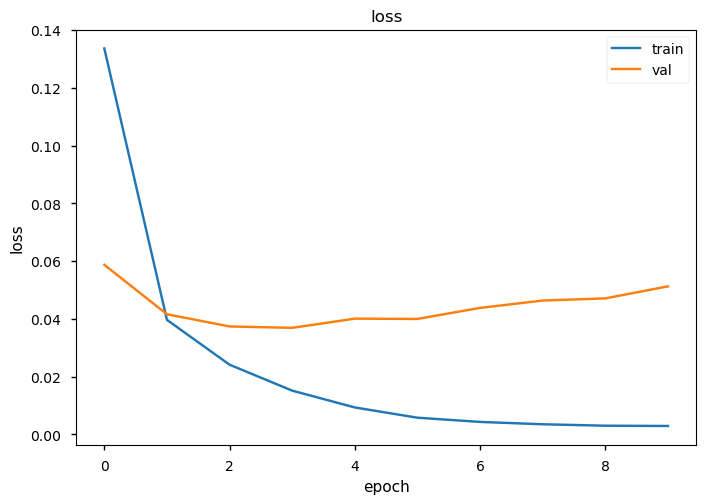

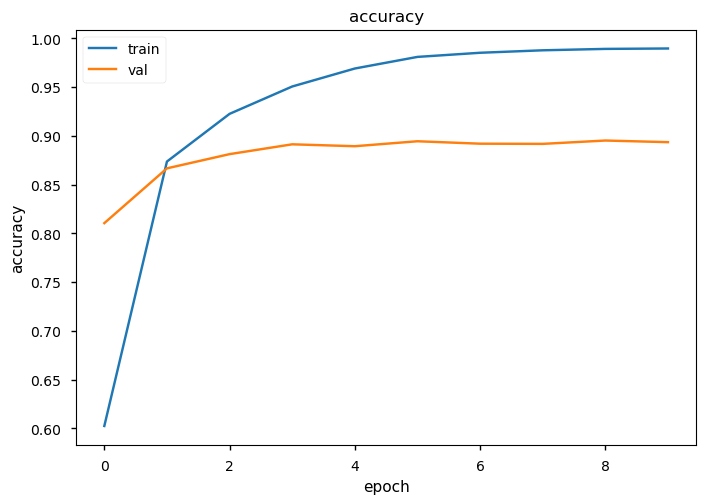

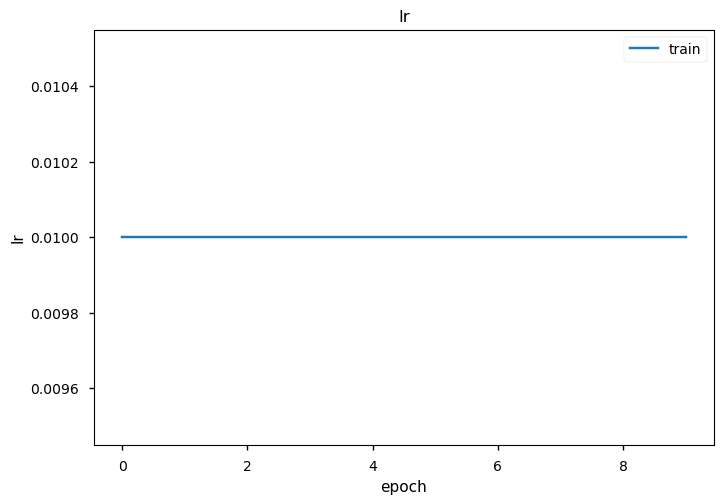

In [81]:
show_history(double_lstm_history)

## Double Fully Connected Layer model

The second, and last, model that we will train is the one with the 2 fully connected layers. The procedure will be exactly the same as before and we will use the same callbacks also for this training


In [82]:
double_fc_filepath = os.path.join(os.getcwd(), DOUBLE_FC + ".pickle")
double_fc_hyperparams = restore_params_from_file(double_fc_filepath)

In [83]:
def create_doubleFC_model(hyperparamsDict: Dict[str, str]):
    
    input = layers.Embedding(input_dim = len(word_to_idx), 
                              output_dim = EMBEDDING_DIMENSION, 
                              input_length=max_sequence_length,
                              weights = [embeddings],
                              trainable = False, # do not train embeddings
                              mask_zero = True)
    
    doubleFC = ks.Sequential()
    doubleFC.add(input)
    
    doubleFC.add(layers.Bidirectional(layers.LSTM(int(hyperparamsDict[LSTM_UNITS]),
                                                  return_sequences = True)))
    
    doubleFC.add(layers.TimeDistributed(layers.Dense(
                    int(hyperparamsDict[FC_UNITS]), 
                    activation= hyperparamsDict[FC_ACTIVATIONS])))
                
    doubleFC.add(layers.TimeDistributed(layers.Dense(len(tags_listing) + 1, activation='softmax')))

    if hyperparamsDict[OPTIMIZER] == 'Adam':
        optimizer = ks.optimizers.Adam(learning_rate= float(hyperparamsDict[LEARNING_RATE]))
    elif hyperparamsDict[OPTIMIZER] == "SGD":    
        optimizer = ks.optimizers.SGD(learning_rate=float(hyperparamsDict[LEARNING_RATE]))
    elif hyperparamsDict[OPTIMIZER] == "RMSProp": 
        optimizer = ks.optimizers.RMSprop(learning_rate=float(hyperparamsDict[LEARNING_RATE]))
    else:
        raise
    
    
    doubleFC.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])
    
    return doubleFC

In [84]:
doubleFC_model = create_doubleFC_model(double_fc_hyperparams)

doubleFC_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 249, 50)           547400    
                                                                 
 bidirectional_2 (Bidirectio  (None, 249, 256)         183296    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 249, 64)          16448     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 249, 46)          2990      
 tributed)                                                       
                                                                 
Total params: 750,134
Trainable params: 202,734
Non-trainable params: 547,400
__________________________________________

In [85]:
double_fc_history = doubleFC_model.fit(x_train, y_train, epochs  = EPOCHS, validation_data= (x_val, y_val), 
                     batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/15
123/123 [==============================] - 50s 361ms/step - loss: 0.0994 - accuracy: 0.7128 - val_loss: 0.0529 - val_accuracy: 0.8339 - lr: 0.0100
Epoch 2/15
123/123 [==============================] - 39s 318ms/step - loss: 0.0372 - accuracy: 0.8863 - val_loss: 0.0420 - val_accuracy: 0.8668 - lr: 0.0100
Epoch 3/15
123/123 [==============================] - 38s 312ms/step - loss: 0.0243 - accuracy: 0.9244 - val_loss: 0.0389 - val_accuracy: 0.8809 - lr: 0.0100
Epoch 4/15
123/123 [==============================] - 39s 320ms/step - loss: 0.0154 - accuracy: 0.9512 - val_loss: 0.0387 - val_accuracy: 0.8870 - lr: 0.0100
Epoch 5/15
123/123 [==============================] - 39s 318ms/step - loss: 0.0098 - accuracy: 0.9689 - val_loss: 0.0426 - val_accuracy: 0.8868 - lr: 0.0100
Epoch 6/15
123/123 [==============================] - 39s 319ms/step - loss: 0.0067 - accuracy: 0.9794 - val_loss: 0.0430 - val_accuracy: 0.8919 - lr: 0.0100
Epoch 7/15
123/123 [==============================] 

In [91]:
doubleFC_weightsFilePath = os.path.join(doubleFC_weightsPath, DOUBLE_FC + '.h5')

doubleFC_model.save_weights(doubleFC_weightsFilePath)
print("Weights successfully saved!")

Weights successfully saved!


### Training history of the model

Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
Couldn't find validation values for metric: lr


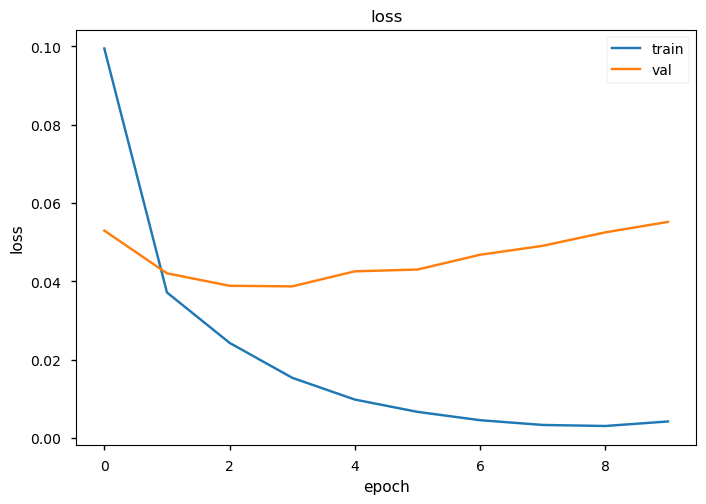

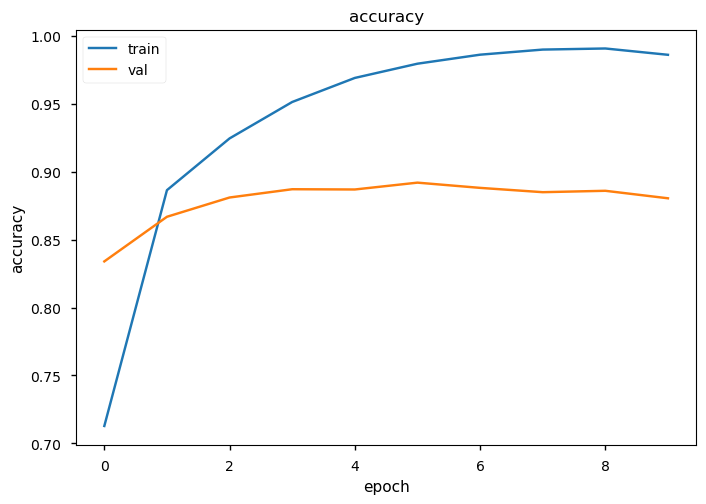

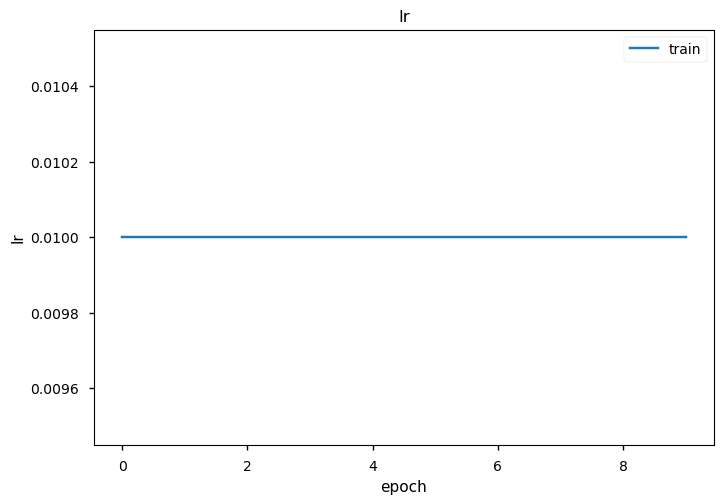

In [92]:
show_history(double_fc_history)

# Evaluation of the models

In this section we will evaluate the performances of the two models on the test set. To emulate a real case scenario, we decided to make a function which takes in input the list of tokens and produces the POS tag for each sentence. In this way, the word will be indexed by the function and not by the user, before producing the results. 

In [93]:
def clip_outputs(predictions: List[List[List[float]]], sentences_len: List[int]) -> List[List[List[float]]]:
    """
    This function helps clipping the lengths of the output of the network to the right length of the original
    sentence.
    
    :param predictions: output of the neural network
    :param  sentences_len: list containing the original lengths of the sentences
    
    :return y_clipped: output of the neural network clipped at the right length
    """
    
    y_clipped = []
    
    assert len(predictions) == len(sentences_len), "You must provide the same number of predictions and sentences lengths"
    
    for i, prediction in enumerate(predictions):
        if sentences_len[i] < max_sequence_length:
            y_clipped.append(prediction[0: sentences_len[i]])
        else:
            y_clipped.append(prediction) # If the length of the sentence is not less than max_sequence_len the sentence does not
                                        # need to be truncated

    return y_clipped



def produce_pos(model: ks.Model, texts: List[str])-> List[List[str]] : 
    """
    The following function, given a list of sentences, splitted in tokens, produces the 
    POS tag for each token of each sentence.
    
    :param texts: List of sentences of which the user want to have the POS tagging.
    
    :return pos_tags_list: List which is composed of lists. Each inner list contains the
    POS tag for each word in the original text.
    """
    
    assert (len(texts) > 0), "You must feed the network at least one sentence!"
    
    pos_tags_list = []
    splitted_texts = []     
    x_test = [] # data that will be fed to the network
    
    
    sentences_len = [len(x) for x in texts]

    
    # Convert all the sentences into their token
    for sentence in texts:
      try:  
        x_test.append([word_to_idx[word] for word in sentence])
      except:
        x_test.append("-OOV-") # Append out of vocabulary token in case the word is not in the vocabulary 
    
    x_test = ks.utils.pad_sequences(x_test, max_sequence_length, padding='post', truncating = 'post',
                                     value = PADDING_TOKEN_VAL)
    
    y_pred = model.predict(x_test)

    
    #For each output, we only care about the results for the first n tokens, where n is the length of the sentence
    y_clipped_predictions = clip_outputs(y_pred, sentences_len)
    
    for sentence in y_clipped_predictions:
      pos_tags_list.append([idx_to_tag[get_value_from_one_hot(sentence[i])] for i in range(len(sentence))])
    
    
    return pos_tags_list

## Metrics

We will evaluate the performances of both models on unseen data using the F1 macro score. For evaluation purposes we will not use all the classes but we will remove the classes which are related to punctuation. <br>
The F1 score, in a binary case is defined as:
$$ F1 = 2 * \frac{precision\  \cdot \ recall}{precision \ + \ recall} $$

In a multiclass setting as this one, we need to use some form of averaging. Some of the most common are *micro*, *macro*, *weighted*. As said before, the score will be computed using the F1 macro score. <br> The macro averaging consists into the computation of the metrics for each label in a binary setting (belongs to the class vs  does not belong to the class) and then find the unweighted mean of the F1 scores obtained.

In [94]:
PUNCTUATION_TAGS = ['#', '$', "''", ',' ,  '.', ':', '-LRB-', '-RRB-', '``']


def get_eval_tags():
    """
    The function produces the list of tags that have to be included in the 
    evaluation for the f1_score
    
    
    """
    eval_tags = []
    
    for key in idx_to_tag.keys():
        if idx_to_tag[key] not in PUNCTUATION_TAGS:
            eval_tags.append(idx_to_tag[key])
    
    return np.array(eval_tags)


def flattener(matr):
    """
    The function transforms the matrix into a 1d array, which is required in input by the 
    metrics
    
    :param matr: list of senquence to be flattened
    
    :return flat: flattened list 
    """
    flat = []
    
    for sequence in matr:
        for elem in sequence:
            flat.append(str(elem))
    
    return np.array(flat)
    
    
    


def compute_metrics(y_pred, y_true):
    """
    The function allows to compute the f1 score on a list of sentences
    :param y_pred: POS tag predicted by the network:
    :param y_true: True POS tag
    
    :return metrics for the given data
    """
    y_pred_flat = flattener(y_pred)
    y_true_flat = flattener(y_true) 
    
    
    labels = get_eval_tags()
    
    metrics = [
        partial(accuracy_score),
        partial(f1_score, labels = labels, average='macro',zero_division=0)
    ]
    
    metric_names = [
        "accuracy",
        "macro_f1"
    ]
    
    metrics_dict = dict()
    
    for metric, name in zip(metrics, metric_names):
        metrics_dict[name] = metric(y_true_flat, y_pred_flat)
    
    return metrics_dict

Now we first need to extract the list of train sentences from the DataFrame, with the corresponding correct POS tag labels

In [95]:
x_test = df_test[COLUMN_WORDS].to_numpy()
y_true = df_test[COLUMN_TAGS].to_numpy()

# load the weights of the models obtained with the training
doubleLSTM_model.load_weights(doubleLSTM_weightsFilePath)
doubleFC_model.load_weights(doubleFC_weightsFilePath)

In [96]:
print("Prediction for the double LSTM model")
y_doubleLSTM = produce_pos(doubleLSTM_model ,x_test)

print("Predictions for the double FC model")
y_doubleFC = produce_pos(doubleFC_model, x_test)

print("Predictions complete for both sets!")

Prediction for the double LSTM model
21/21 [==============================] - 8s 162ms/step
Predictions for the double FC model
21/21 [==============================] - 4s 117ms/step
Predictions complete for both sets!


# Evaluation of the models

Now we will compute the metrics for both models, using the function defined above

In [97]:
doubleLSTM_metrics = compute_metrics(y_doubleLSTM, y_true)

print("Results obtained with the model:")
for metric_name in doubleLSTM_metrics.keys():
    print("{0}:\t{1}".format(metric_name, doubleLSTM_metrics[metric_name]))


Results obtained with the model:
accuracy:	0.9038275972981666
macro_f1:	0.7003775790838596


In [98]:
doubleFC_metrics = compute_metrics(y_doubleFC, y_true)

print("Results obtained with the model:")
for metric_name in doubleFC_metrics.keys():
    print("{0}:\t{1}".format(metric_name, doubleFC_metrics[metric_name]))

Results obtained with the model:
accuracy:	0.899002894821486
macro_f1:	0.699283779507188


# Error Analysis

In this section we will discuss and analyze the errors made by both models, trying to find and explain the causes of the errors done by both models.<br>
Before we dive into the analysis of the errors for each model, we want to inspect the distribution of tags into the three different sets, trying to understand if the tags have a similar distribution across the whole dataset or if each dataset has its distribution of tag. <br>
This is an important aspect to consider because ML is based on the hypothesis that the training set will be representative for the true distribution of data (in our case of POS tags), so if this hypothesis is not matched in the distribution we have already found a cause of errors at prediction time.

In [99]:
def get_counts(list_of_tags: List[str], tag_to_idx: Dict[str,int]) ->  np.array:
    counts = np.zeros(len(tag_to_idx.keys()))
    
    for tag in list_of_tags:
        idx = tag_to_idx[tag]
        counts[idx] += 1
    
    return counts


def plot_histogram(df: pd.DataFrame, tag_to_idx: Dict[str, int]) -> np.array:
    """
    The function allows to plot the distribution of the tags with an histogram in the distribution
    and returns the counts of the tags
    
    :param df: DataFrame containing data
    :tags_list: unique list of tags, will represent the labels of the histrogram
    
    :return counts: count of tag inside the set for each tag
    
    """
    
    tags_label = list(tag_to_idx.keys())
    
    list_of_tags = df[COLUMN_TAGS].to_numpy()
    flat_list = flattener(list_of_tags)
    
    counts = get_counts(flat_list, tag_to_idx)
    
    # We remove both the padding token and the relative count because they are not in the dataframes but are manually
    # added later
    
    tags_label = tags_label[1:]
    counts = counts[1:]
    
    
    plt.figure()
    plt.bar(tags_label, counts, align="center")
    plt.xticks(rotation='vertical')
    plt.show()
    
    return counts
    


Let's start by inspecting the training set


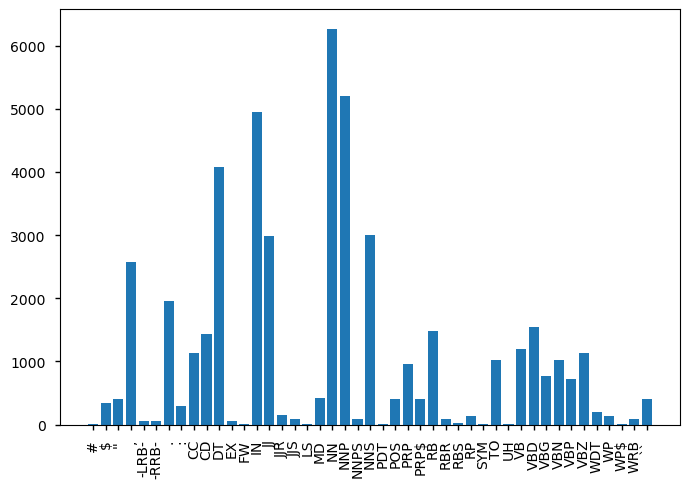

In [100]:
train_counts = plot_histogram(df_train, tag_to_idx)

As it was easy to guess, the dataset is highly unbalanced but in a real world scenario we also have some kind of unbalancing among different part of speech, which may result into worst performances in identifying classes with fewer examples in the training set, misclassifying them.

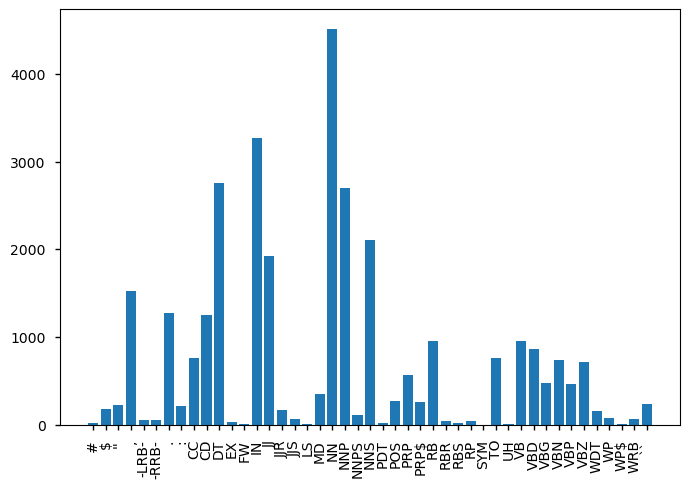

In [101]:
val_counts = plot_histogram(df_val, tag_to_idx)

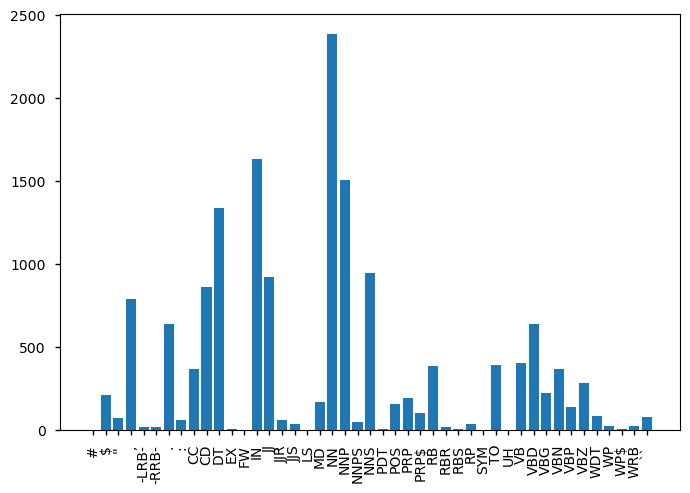

In [102]:
test_counts = plot_histogram(df_test, tag_to_idx)

Now let's inspect the differences among the counts between the training set and both validation and test set

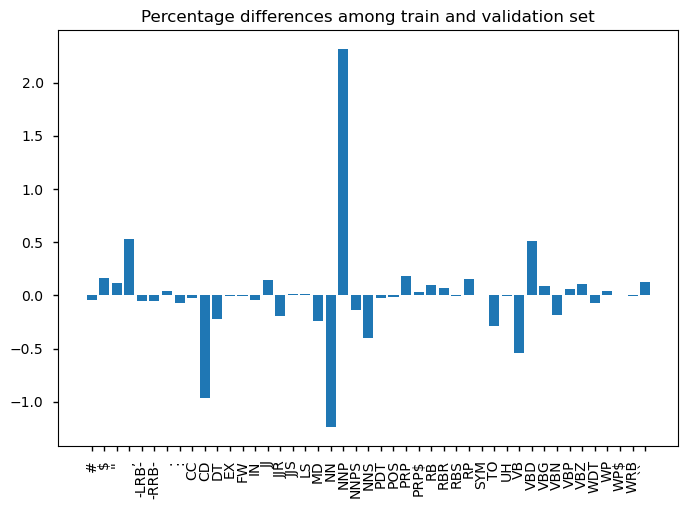

In [103]:
train_dist_percentages = np.array([x * 100 / np.sum(train_counts) for x in train_counts])
val_dist_percentages = np.array([x * 100 / np.sum(val_counts) for x in val_counts])

trainVal_differences = train_dist_percentages - val_dist_percentages

tags_list = list(tag_to_idx.keys())[1:]


plt.figure()
plt.bar(tags_list,trainVal_differences, align='center')
plt.xticks(rotation='vertical')
plt.title("Percentage differences among train and validation set")
plt.show()

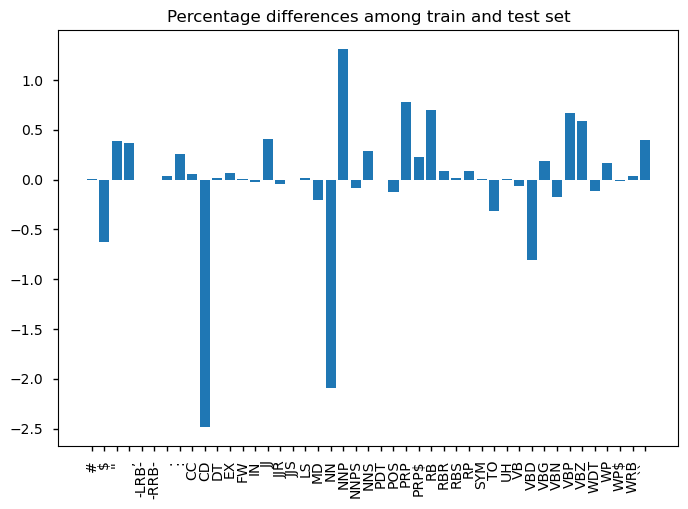

In [104]:
test_dist_percentages = np.array([x * 100/ np.sum(test_counts) for x in test_counts])

trainTest_differences = train_dist_percentages - test_dist_percentages

tags_list = list(tag_to_idx.keys())[1:]


plt.figure()
plt.bar(tags_list,trainTest_differences, align='center')
plt.xticks(rotation='vertical')
plt.title("Percentage differences among train and test set")
plt.show()

As we can see from this plot there are some differences in the relative distributions of the samples in the sets, but the distributions are similar among them, so the distributions of the sets do not represent a potential harm to the learning of the network.

Now we can start focusing on each model and inspect the sources of errors produced by its prediction

 ## Double LSTM Model

We start inspecting the performances of our model by looking at the  classificationn report produced on the test set. This allows us to see the precison, recall and f1-score for each different tag in our set. This analysis may help us finding which are the classes the model struggles to classify correctly.

In [105]:
flat_y_true = flattener(y_true)

print(classification_report(flat_y_true, flattener(y_doubleLSTM), zero_division=0))

              precision    recall  f1-score   support

           $       0.97      1.00      0.99       209
          ''       1.00      0.99      0.99        70
           ,       1.00      1.00      1.00       787
       -LRB-       0.60      0.50      0.55        18
       -RRB-       0.62      0.56      0.59        18
           .       1.00      1.00      1.00       638
           :       0.98      1.00      0.99        56
          CC       0.98      0.99      0.99       366
          CD       0.97      0.97      0.97       858
          DT       0.99      0.99      0.99      1335
          EX       1.00      1.00      1.00         5
          IN       0.97      0.97      0.97      1630
          JJ       0.71      0.80      0.75       918
         JJR       0.79      0.53      0.63        59
         JJS       0.90      0.61      0.73        31
          MD       0.98      0.99      0.98       167
          NN       0.85      0.85      0.85      2383
         NNP       0.88    

From the classification report we want to focus our attention on some of the classes which present low f1-scores. In particular we will focus on:
* **PDT** which is the most problematic class, since it has a f1-score of 0.00
* **NNPS** that has a low recall and low precision
* **RBS** with a low precision, high recall and low support
* **RBR** with a low support and low precision

### PDT - Predeterminer            

First of all let's try to understand what a predeterminer is: in grammar, a predeterminer is a word that is sometimes used before a determiner to give more information about a noun in a noun phrase. <br>
For example, in the phrases "all these children" and "once a day" the words "all" and "once'" are predeterminers. <br>

First of all we can investigate in which sentences a predeterminer is found in the training set, then in the test set and let's see for the latter how the POS tagging is made by the model.

In [106]:
def recreate_sentence(splitted_sentence: List[str]) -> str:
    """
    Given a list of words, recreates the original sentence
    
    :param  splitted_sentence:  splitted sentence
    
    :return sentence: the sentence not splitted
    
    """
    sentence = splitted_sentence[0] + " "
    
    for i in range(1, len(splitted_sentence)):
        sentence += splitted_sentence[i] + " "
        
    return sentence
    



def get_sentences_with_a_given_tag(df: pd.DataFrame, tag: str, limit: int = -1, print_sentences: bool = True) -> List[int]:
    """
    The function allows to print the sentences in which there is a given tag, from a given DataFrame
    
    :param df: DataFrame containing the sentences and the tags
    :param tag: tag we want to find
    :param limit: max number of sentences to print, if is -1, then all the sentences will be collected
    
    :return sentences_idx: the indexes of the sentences
    
    """
    
    rows = df.shape[0]
    found = 0
    sentences_list = []
    sentences_idx = []
    sentences_pos = []
    
    assert limit > -2 and limit != 0, "The limit parameter must either be positive or -1 if you want all the sentences"
    
    for i in range(rows):
        sentence_tag = df.iloc[i][COLUMN_TAGS]
        if tag in sentence_tag:
            sentences_pos.append(sentence_tag)
            sentences_idx.append(i)
            sentence = recreate_sentence(df.iloc[i][COLUMN_WORDS])
            sentences_list.append(sentence)
            found += 1
            
            if found == limit:
                break
    
    if found == limit:
        print("Found the max number of sentences asked")
    elif found > 0:
        print("Found {0} sentences".format(found))
    else:
        print("No sentences with the given tag have been found")
    
    print()
    
    if print_sentences:
        for i, sentence in enumerate(sentences_list):
            print("{0}: {1}".format(i,sentence))

    return sentences_idx
    
    

In [107]:
# we do not save the indexes because we do not need them now, we will save them for the test set

get_sentences_with_a_given_tag(df_train, "PDT", limit = -1)

Found 9 sentences

0: but he has not said before that the country wants half the debt forgiven . 
1: `` wilder has managed to get across the idea that coleman will say anything to get elected governor and -- more important -- has been able to put the onus for all the negative campaigning on coleman . '' 
2: `` the message to the board of education out of all this is we 've got to take a serious look at how we 're doing our curriculum and our testing policies in this state , '' said the talk-show host . 
3: on the back , the shirts read , `` we have all the answers . '' 
4: a spokesman for temple estimated that sea containers ' plan -- if all the asset sales materialize -- would result in shareholders receiving only $ 36 to $ 45 a share in cash . 
5: troubled nbi inc. said it fired more than half its work force and is discontinuing its hardware business to focus on its software and service operations . 
6: such an editorial point of view perpetuates an insidious , stereotyped perspectiv

[240, 608, 792, 801, 1183, 1736, 1805, 1870, 1907]

As we can already see, this tag is rarely used inside the whole train dataset. Let's now check its support in the test set

In [108]:
sentences_indexes = get_sentences_with_a_given_tag(df_test, "PDT", limit = -1)

Found 4 sentences

0: but it is n't clear yet whether the central bank will make such a move . 
1: all this has cast a pall over columbia savings & loan association and its high-rolling 43-year-old chairman , thomas spiegel , who built the $ 12.7 billion beverly hills , calif. , thrift with high-yield junk bonds . 
2: while many problems would attend a restructuring of columbia , investors say mr. spiegel is mulling such a plan to mitigate columbia 's junk problems . 
3: columbia wo n't comment on all the speculation . 


In [109]:
for i,index in enumerate(sentences_indexes):
    print("For the sentence number: {0}\n the correct POS tagging is:\n {1} \n The one made by the model is:\n {2}\n\n".format(i,y_true[index], y_doubleLSTM[index]))

For the sentence number: 0
 the correct POS tagging is:
 ['CC', 'PRP', 'VBZ', 'RB', 'JJ', 'RB', 'IN', 'DT', 'JJ', 'NN', 'MD', 'VB', 'PDT', 'DT', 'NN', '.'] 
 The one made by the model is:
 ['CC', 'PRP', 'VBZ', 'RB', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NNP', 'MD', 'VB', 'JJ', 'DT', 'NN', '.']


For the sentence number: 1
 the correct POS tagging is:
 ['PDT', 'DT', 'VBZ', 'VBN', 'DT', 'NN', 'IN', 'NNP', 'NNPS', 'CC', 'NNP', 'NNP', 'CC', 'PRP$', 'JJ', 'JJ', 'NN', ',', 'NNP', 'NNP', ',', 'WP', 'VBD', 'DT', '$', 'CD', 'CD', 'NNP', 'NNP', ',', 'NNP', ',', 'NN', 'IN', 'JJ', 'NN', 'NNS', '.'] 
 The one made by the model is:
 ['DT', 'DT', 'VBZ', 'VBN', 'DT', 'NN', 'IN', 'NNP', 'NNPS', 'CC', 'NNP', 'NNP', 'CC', 'PRP$', 'JJ', 'JJ', 'NN', ',', 'NNP', 'NNP', ',', 'WP', 'VBD', 'DT', '$', 'CD', 'CD', 'NNP', 'NNP', ',', 'NNP', ',', 'NN', 'IN', 'JJ', 'NNS', 'NNS', '.']


For the sentence number: 2
 the correct POS tagging is:
 ['IN', 'JJ', 'NNS', 'MD', 'VB', 'DT', 'NN', 'IN', 'NNP', ',', 'NNS', 'VBP', 'NNP'

As we can see our model failed to recognize this tag, wrongly classifying it all the times. In particular, of the 4 times the tag PDT appeared in the test set, it has been identified twice as adjective and twice as Determiner. <br>
Predeterminers, and the same can be said for determiners can be easily confused with adjectives because of the position they take in the sentence (before the noun) and because of the role they have in the sentence (they are used to identify a noun). <br>
A possible way to fix this mis-classification would be to give more examples of predeterminers in the raining set, so the model may be able to learn from them,  in fact predeterminers only represent the 0.00019% of the whole training set (9 words tagged as PDT on 47356).

### NNPS - Proper noun, plural

In this case we do not need to explain what the tag represent, instead we want to see how the tags have been misclassified by the model and try to analyize what may be the root cause for the errors

In [110]:
def get_false_negative_info(df: pd.DataFrame, misclassified_idx: List[int], target_tag: str, y_true: List[List[str]], 
                           y_pred: List[List[str]]) -> Tuple[
                                                        Dict[int, List[str]],
                                                        Dict[int, List[int]],
                                                        Dict[str, int]
                                                    ]:
    """
    The function gets all the false negatives for a given target tag in a DataFrame, given the indexes in which
    you have the misclassified tag.
    
    :param df: DataFrame in which there are the misclassified sentences
    :param misclassified_idx: list containing all the row numbers of the misclassified sentences in the given df
    :param target_tag: tag we are inspecting
    :param y_true: Gold standard for the classification
    :param y_pred: Predictions given by the model
    
    :return
            position_of_the_error: Dict containing for each misclassified sentence the position of the 
                                   misclassified tag in the sentence
            predicted_tag: Dict containing the predicted tag for each sentence
            error_frequency: Dict containing the number of times the tag has been predicted, making a mistake
    """
    
    position_of_the_error = {}
    predicted_tag = {}
    error_frequency = {}
    
    for idx in misclassified_idx:
        
        #Initialize the lists of errors for the sentence
        position_errors = []
        predicted_tags = []
        
        
        for position, tag in enumerate(y_true[idx]):
            if tag == target_tag and tag != y_pred[idx][position]: # if the tag is misclassified
                error = y_pred[idx][position]
                position_errors.append(position)
                predicted_tags.append(error)
                error_frequency[error] = error_frequency.get(error, 0) + 1 
        
        # Add the found errors with the given tag in the sentence
        if len(position_errors) > 0:
            position_of_the_error[idx] = position_errors
            predicted_tag[idx] = predicted_tags
            
    
    return (position_of_the_error, predicted_tag, error_frequency)



def get_false_positive_info(df: pd.DataFrame, target_tag: str, y_true: List[List[str]], 
                           y_pred: List[List[str]]) -> Tuple[
                                                        Dict[int, List[str]],
                                                        Dict[int, List[int]],
                                                        Dict[int, List[str]],
                                                        Dict[str, int]
                                                    ]:
    """
    The function gets all the false positive for a given target tag in a DataFrame, given the indexes in which
    you have the misclassified tag.
    
    :param df: DataFrame in which there are the misclassified sentences
    :param target_tag: tag we are inspecting
    :param y_true: Gold standard for the classification
    :param y_pred: Predictions given by the model
    
    :return
            position_of_the_error: Dict containing for each misclassified sentence the position of the 
                                   misclassified tag in the sentence
            true_tag: Dict containing the true tag for each sentence
            misclassified_words: Dict containing all the target_tag false positives
            error_frequency: Dict containing the number of times the tag has been predicted, making a mistake
    """
    
    position_of_the_error = {}
    true_tag = {}
    misclassified_words = {}
    error_frequency = {}
    
    for idx, sentence_predictions in enumerate(y_pred):
        sentence = df.iloc[idx][COLUMN_WORDS]
        
        #Initialize the lists of errors for the sentence
        position_errors = []
        true_tags = []
        miscl_words = []
        
        
        for position, predicted_tag in enumerate(sentence_predictions):
            if predicted_tag == target_tag and predicted_tag != y_true[idx][position]: # if the tag is a FP
                
                error = y_true[idx][position]
                position_errors.append(position)
                true_tags.append(error)
                miscl_words.append(sentence[position])
                error_frequency[error] = error_frequency.get(error, 0) + 1 
        
        # Add the found errors with the given tag in the sentence
        if len(position_errors) > 0:
            position_of_the_error[idx] = position_errors
            true_tag[idx] = true_tags
            misclassified_words[idx] = miscl_words
            
    
    return (position_of_the_error, true_tag, misclassified_words, error_frequency)


In [111]:
nnps_test_idx = get_sentences_with_a_given_tag(df_test, 'NNPS', print_sentences=False)

pos_error, pred_tag, error_frequency = get_false_negative_info(df_train, nnps_test_idx, "NNPS", y_true, y_doubleLSTM)

print("The number of false negatives is: ", np.sum(list(error_frequency.values())))
print("Distribution of false negatives for NNPS tag : ")
print(error_frequency)

Found 41 sentences

The number of false negatives is:  37
Distribution of false negatives for NNPS tag : 
{'NNP': 13, 'NNS': 20, 'VBP': 1, 'VBD': 1, 'RBR': 1, 'JJ': 1}


In [112]:
fp_pos_error, true_tags, misclassified_words , fp_error_freq = get_false_positive_info(df_test, "NNPS", y_true, y_doubleLSTM)

print("The number of false negatives is: ", np.sum(list(fp_error_freq.values())))
print("Distribution of false positive for NNPS tag : ")
print(fp_error_freq)

The number of false negatives is:  10
Distribution of false positive for NNPS tag : 
{'NNS': 5, 'NNP': 3, 'NN': 1, 'VBG': 1}


As it is possible to see from the inspection of the error distributions for the given tag, the majority of errors done, both false positives and false negatives are because the model still considers the term as a noun. In the majority of cases it is connsidered as a plural name, predicting correctly also the cardinality of the name.

### RBR - Adverb comparative

As done for the proper name, lets investigate the errors done by the network for this tag and then let's discuss them 

In [113]:
rbr_test_idx = get_sentences_with_a_given_tag(df_test, 'RBR', print_sentences=True)

Found 15 sentences

0: a shift to producing more alcohol and less sugar had been expected , but the latest news , if true , indicates a more drastic shift than had been anticipated . 
1: that designation would , among other things , provide more generous credit terms under which the soviets could purchase grain . 
2: prudential-bache securities boosted the stock 's short-term investment rating in response to the departure ; analyst john mcmillin said he believes the company will turn to new management `` that 's more financially oriented . '' 
3: the sweetened offer has acceptances from more than 50 % of weisfield 's shareholders , and it is scheduled for completion by dec. 10 . 
4: house-senate conferees approved major portions of a package for more than $ 500 million in economic aid for poland . 
5: columbia stock recently hit 4 1\/8 , after reaching 11 3\/4 earlier this year on rumors that mr. spiegel would take the thrift private . 
6: but the pharmaceutical company said it `` anti

In [114]:
pos_error, pred_tag, error_frequency = get_false_negative_info(df_train, rbr_test_idx, "RBR", y_true, y_doubleLSTM)

print("The number of false negatives is: ", np.sum(list(error_frequency.values())))
print("Distribution of false negatives for RBR tag : ")
print(error_frequency)

The number of false negatives is:  6
Distribution of false negatives for RBR tag : 
{'JJR': 4, 'RB': 1, 'DT': 1}


In [115]:
fp_pos_error, true_tags, misclassified_words , fp_error_freq = get_false_positive_info(df_test, "RBR", y_true, y_doubleLSTM)

print("The number of false negatives is: ", np.sum(list(fp_error_freq.values())))
print("Distribution of false positive for RBR tag : ")
print(fp_error_freq)

The number of false negatives is:  26
Distribution of false positive for RBR tag : 
{'JJR': 21, 'IN': 2, 'VBG': 1, 'NNPS': 1, 'NN': 1}


As concerns the false negatives, the most frequent error is idenntifying the adverb as asjective. The model seems capable to understand that it is a comparative but struggles in distinguishing adverbs from adjectives.  <br>
For false positives instead the model mainly identifies comparative adjectives as adverbs, and this is probably due to the lexical similarity in the formation of regular comparatives in english. 

### RBS -  Adverb, superlative

As done for the other classes, let's investigate the support of the tag in the test set, and then the false positives. We do not look for false negatives because there are not, since the recall is 1.

In [116]:
rbs_test_idx = get_sentences_with_a_given_tag(df_test, 'RBS', print_sentences=True)

Found 3 sentences

0: most important , ms. ganes noted , `` brazilian officials said that no decision has as yet been made on the suspension of exports . '' 
1: traders said prices also were supported by widespread rumors that the soviet union is on the verge of receiving most favored nation status from the u.s. . 
2: the soviet union bought roughly 310 million bushels of u.s. corn in october , which is the most ever sold to the soviet union in one month from the u.s. . 


In [117]:
fp_pos_error, true_tags, misclassified_words , fp_error_freq = get_false_positive_info(df_test, "RBS", y_true, y_doubleLSTM)

print("The number of false negatives is: ", np.sum(list(fp_error_freq.values())))
print("Distribution of false positive for RBS tag : ")
print(fp_error_freq)

The number of false negatives is:  6
Distribution of false positive for RBS tag : 
{'JJS': 6}


As for comparatives adverbs the main error here is due to the similarity between adverbs and adjectives in English, thus the network struggles to distinguish clearly between adverbs and adjectives. <br>
Lastly, it is again important to highlight that the support of this class is really low, so having more examples would be beneficial for the network

## Confusion Matrix

To have a more general glance at the errors made by the model we can inspect the results obtained on the set by means of the confusion matrix.

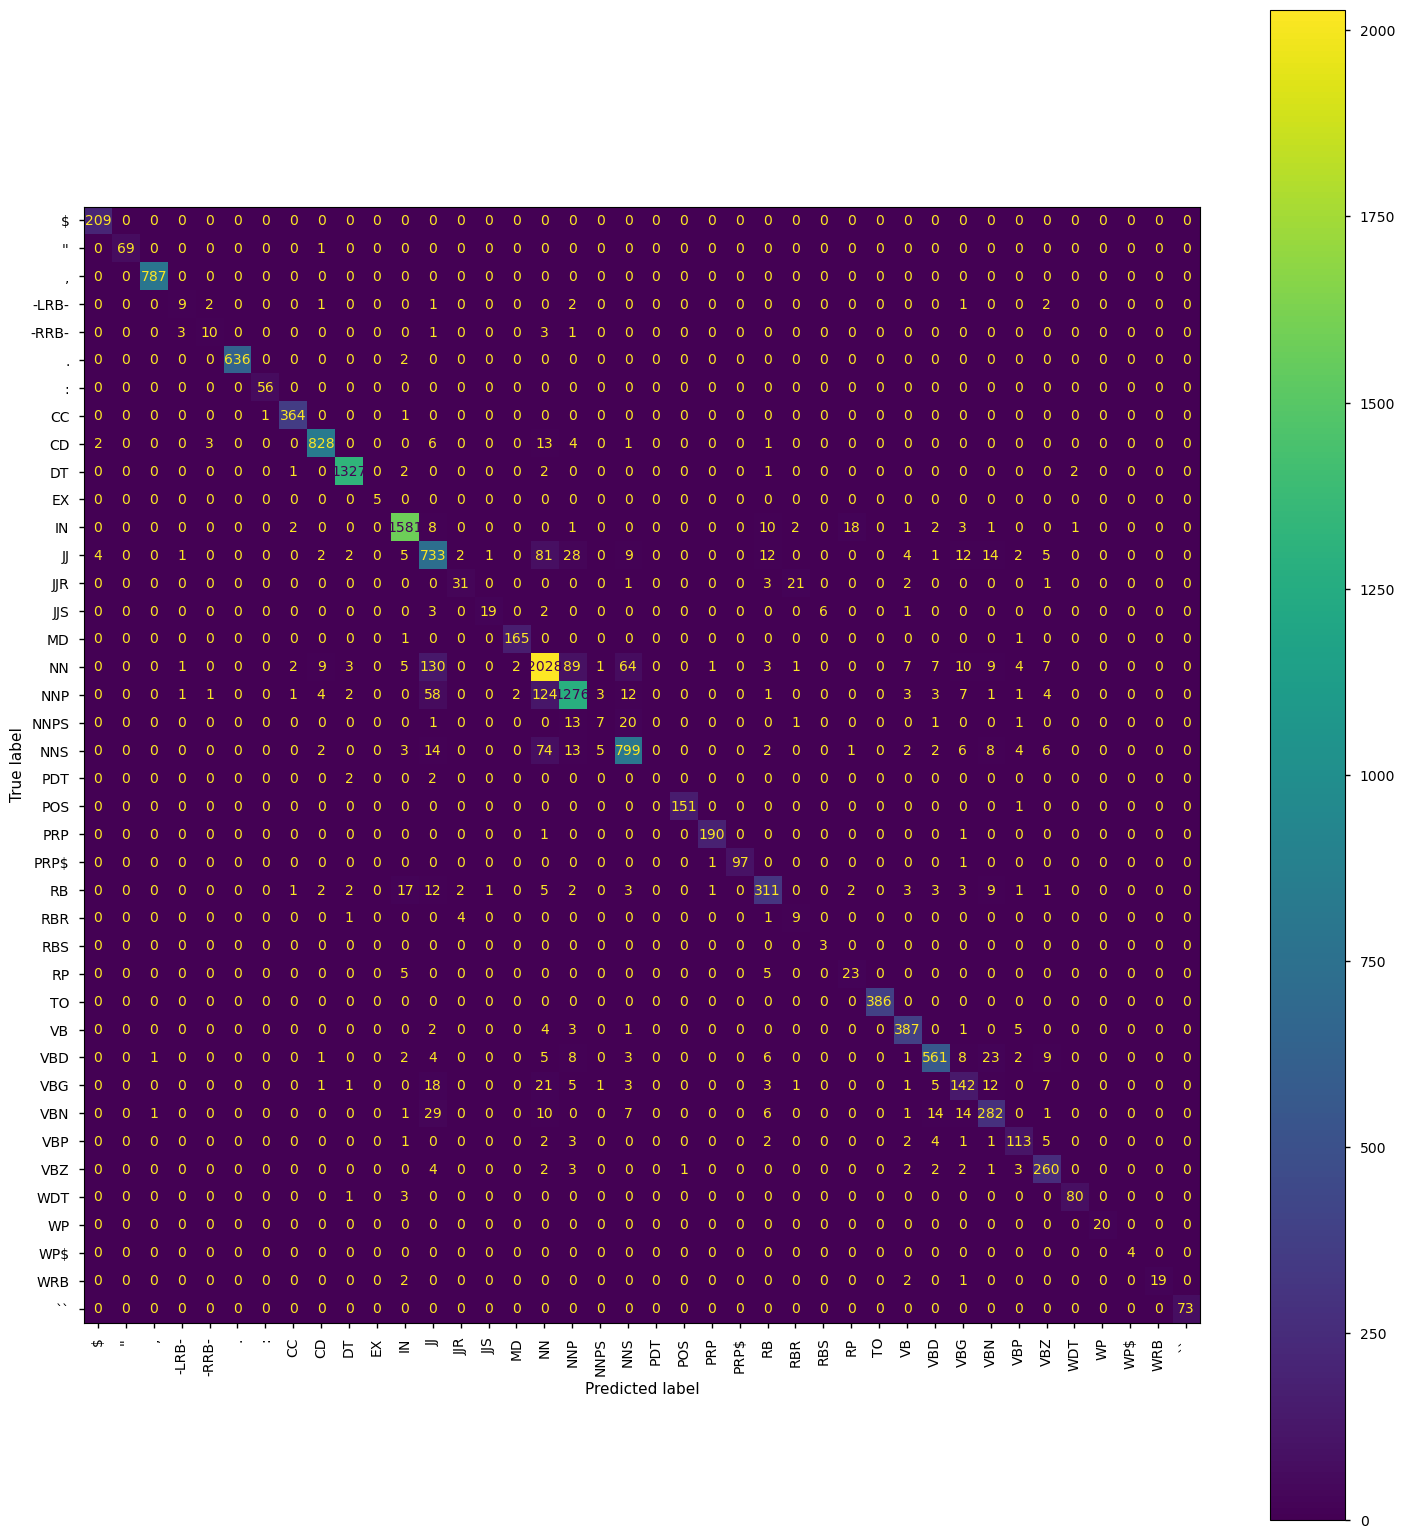

In [118]:
y_true_flat = flattener(y_true)
y_doubleLSTM_flat = flattener(y_doubleLSTM)

conf_matrix = confusion_matrix(y_true_flat, y_doubleLSTM_flat)
display = ConfusionMatrixDisplay(conf_matrix, display_labels = np.unique(y_true_flat))

fig, ax = plt.subplots(figsize=(18,20))

display.plot(ax=ax, xticks_rotation= 'vertical')


An analysis of the confusion matrix allows us to notice that the most relevant errors are:
* **NN-JJ** Nouns predicted as adjectives and viceversa. The model probably struggles in distinguishing the two classes because often they are close to each other in the sentences (this also holds with proper nouns and adjectives);
* **NN-NNP** Predictions of nouns as proper nouns and this is an understandable erorr;
* **RBR-JJR** /  **RBS-JJS** Predicition of adjectives as adverbs and viceversa. This holds both for comparatives and superlatives

Other errors made by the network are related to prediction of singular and plural names which often get confused by the network. In case of proper nouns it is really hard to distinguish whether a proper noun is plural or singular. In the case of common nouns instead, it is really hard to make a correct distinction since the main difference is usually represented by just one letter.

## Double FC model

For this model we will follow the line used in the other case, so we will start inspecting the classification report, then focus on the most problematic classes and inspect them, before concluding with the analysis of the confusion matrix.

In [119]:
print(classification_report(flat_y_true, flattener(y_doubleFC), zero_division=0))

              precision    recall  f1-score   support

           $       0.99      1.00      0.99       209
          ''       0.99      1.00      0.99        70
           ,       1.00      1.00      1.00       787
       -LRB-       0.79      0.61      0.69        18
       -RRB-       0.55      0.67      0.60        18
           .       1.00      1.00      1.00       638
           :       0.98      1.00      0.99        56
          CC       0.99      0.98      0.99       366
          CD       0.97      0.96      0.97       858
          DT       0.98      0.99      0.99      1335
          EX       1.00      1.00      1.00         5
          IN       0.96      0.96      0.96      1630
          JJ       0.73      0.77      0.75       918
         JJR       0.81      0.75      0.78        59
         JJS       0.83      0.77      0.80        31
          MD       0.98      0.99      0.99       167
          NN       0.84      0.87      0.85      2383
         NNP       0.88    

Interestingly, we notice that also in this case the classes the model struggles the most identifying are once again predeterminers (**PDT**) with a f1_score of 0.0, plural proper names (**NNPS**) which show a very low f1-score of 0.08 and comparative adverbs (**RBR**). We will now use the confusion matrix to show which are the main sources of errors of the model, as did before for the first model, and see if the errors made by this model are the same done by the first one.

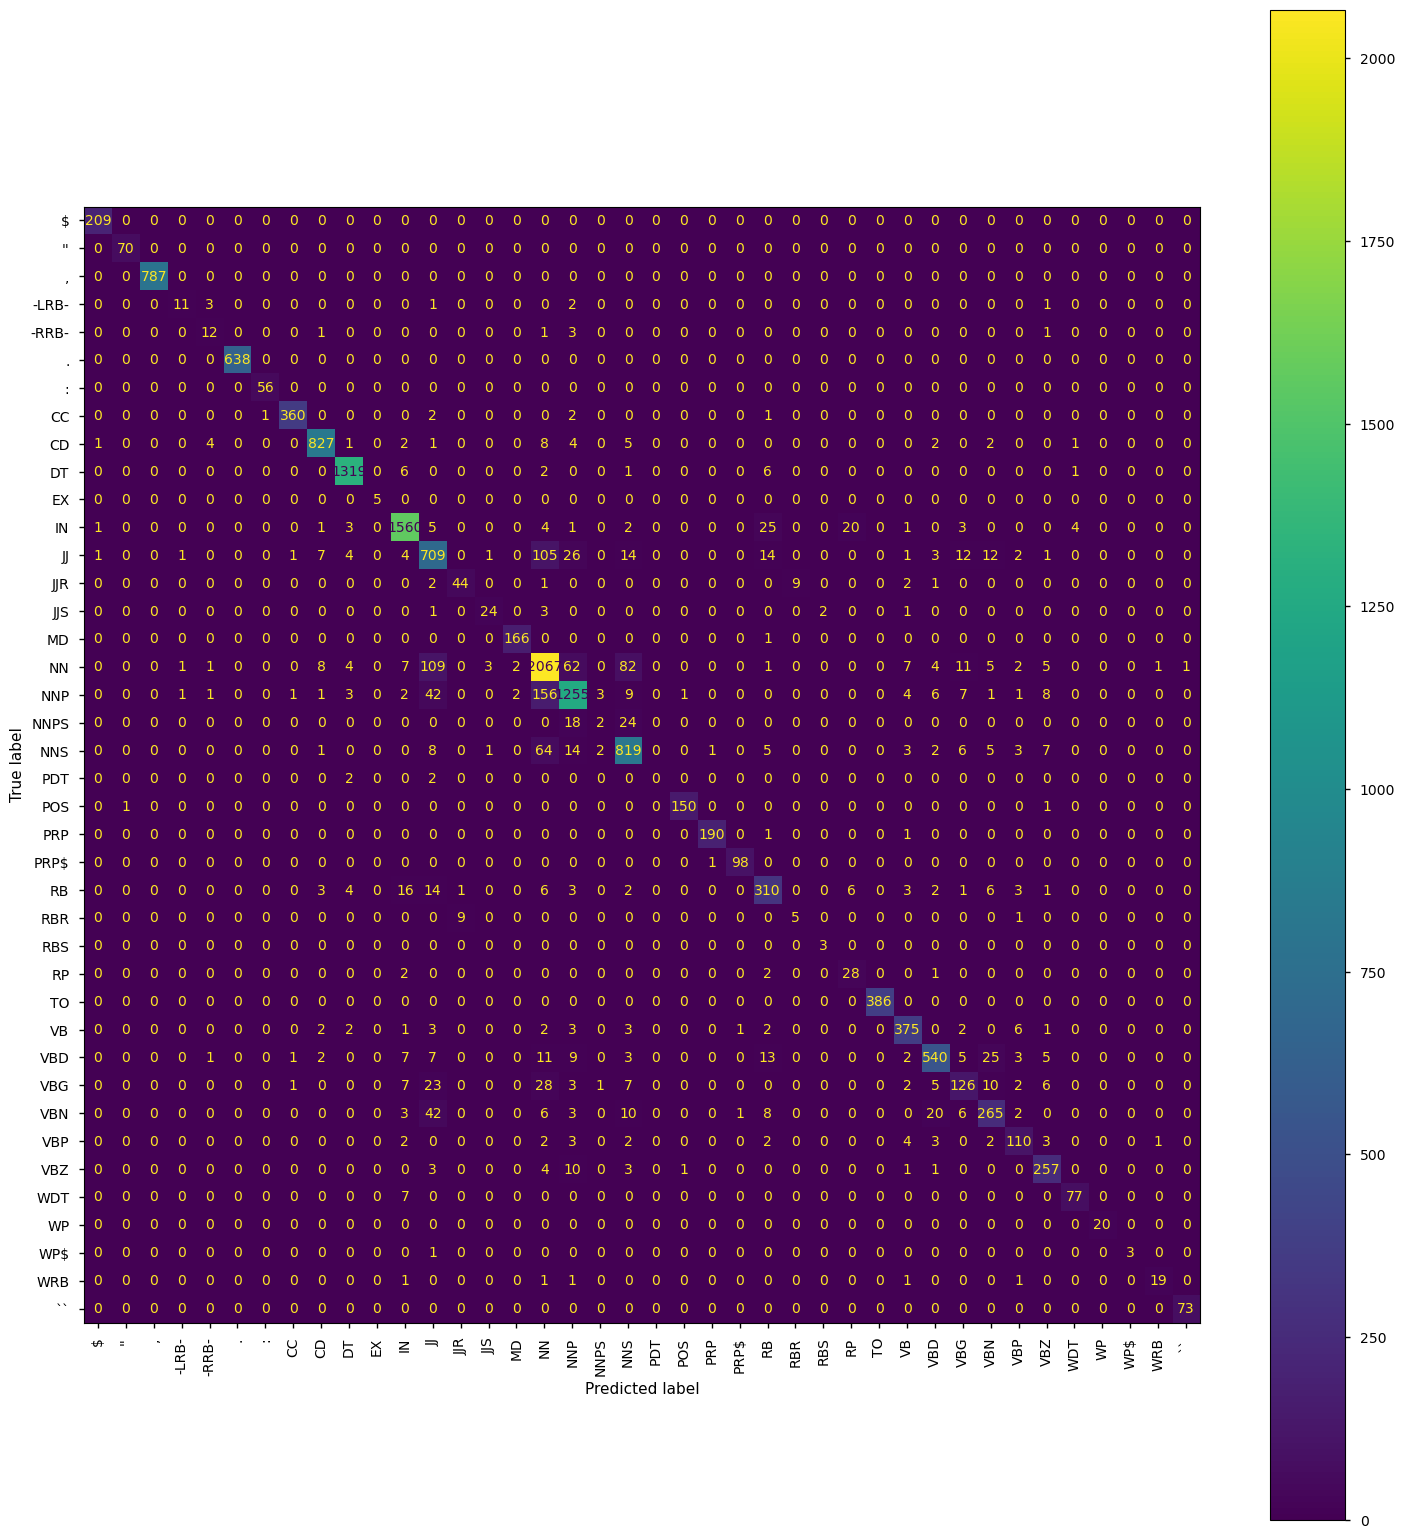

In [120]:
y_doubleFC_flat = flattener(y_doubleFC)

conf_matrix = confusion_matrix(y_true_flat, y_doubleFC_flat)
display = ConfusionMatrixDisplay(conf_matrix, display_labels = np.unique(y_true_flat))

fig, ax = plt.subplots(figsize=(18,20))

display.plot(ax=ax, xticks_rotation= 'vertical')

From this plot we can notice how the kind of errors made are very similar (names and adjectives confused, predeterminers classified as determiners or adjectives and comparative adverbs classified as comparative adjectives). <br>
To compare the two model we want to highlight that the model with 2 LSTM cells showed a slightly better capability of correctly classifying proper names. This can be explained by a higher model capacity (the model with 2 LSTM cells has 100.000 more parameters than the one with two FC layers) which allowed the model to perform slightly better in recognizing this class. <br>

# Improving the results

In the last part of this notebook, we want to try to improve the performances of our best model (Double LSTM model), trying to improve the f1-score. <br>
First of all, we tried, as proposed in [1], to clip the norm of the gradient to a fixed, predefined, value because this could improve performance on sequence labeling task and because it can prevent the issue of exploding gradients.

In [67]:
def clipnorm_model(rate = 0.0):
    
    input = layers.Embedding(input_dim = len(word_to_idx), 
                              output_dim = EMBEDDING_DIMENSION, 
                              input_length=max_sequence_length,
                              weights = [embeddings],
                              trainable = False, # do not train embeddings
                              mask_zero = True)
    
    doubleLSTM = ks.Sequential()
    doubleLSTM.add(input)
    
    doubleLSTM.add(layers.Bidirectional(layers.LSTM(64, return_sequences = True)))
    doubleLSTM.add(layers.Dropout(rate))
    doubleLSTM.add(layers.Bidirectional(layers.LSTM(128, return_sequences = True)))
    doubleLSTM.add(layers.Dropout(rate))
    
    doubleLSTM.add(layers.TimeDistributed(layers.Dense(len(tags_listing) + 1, activation='softmax'))) 
    doubleLSTM.add(layers.Dropout(rate))
    
    optimizer = ks.optimizers.RMSprop(learning_rate=0.01, clipnorm=10)
        
        
    doubleLSTM.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])
    
    return doubleLSTM

In [43]:
model_cn = clipnorm_model()

model_cn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 249, 50)           547400    
                                                                 
 bidirectional_2 (Bidirectio  (None, 249, 128)         58880     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 249, 256)         263168    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 249, 46)          11822     
 tributed)                                                       
                                                                 
Total params: 881,270
Trainable params: 333,870
Non-trainable params: 547,400
__________________________________________

In [44]:
model_cn_history = model_cn.fit(x_train, y_train, epochs  = EPOCHS, validation_data= (x_val, y_val), 
                     batch_size = BATCH_SIZE, callbacks = callbacks)

Epoch 1/15
123/123 [==============================] - 96s 682ms/step - loss: 0.1318 - accuracy: 0.6099 - val_loss: 0.0559 - val_accuracy: 0.8226 - lr: 0.0100
Epoch 2/15
123/123 [==============================] - 72s 585ms/step - loss: 0.0398 - accuracy: 0.8728 - val_loss: 0.0397 - val_accuracy: 0.8680 - lr: 0.0100
Epoch 3/15
123/123 [==============================] - 65s 528ms/step - loss: 0.0243 - accuracy: 0.9222 - val_loss: 0.0372 - val_accuracy: 0.8816 - lr: 0.0100
Epoch 4/15
123/123 [==============================] - 66s 540ms/step - loss: 0.0151 - accuracy: 0.9508 - val_loss: 0.0350 - val_accuracy: 0.8973 - lr: 0.0100
Epoch 5/15
123/123 [==============================] - 62s 509ms/step - loss: 0.0094 - accuracy: 0.9688 - val_loss: 0.0373 - val_accuracy: 0.8946 - lr: 0.0100
Epoch 6/15
123/123 [==============================] - 64s 520ms/step - loss: 0.0059 - accuracy: 0.9809 - val_loss: 0.0409 - val_accuracy: 0.8936 - lr: 0.0100
Epoch 7/15
123/123 [==============================] 

Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
Couldn't find validation values for metric: lr


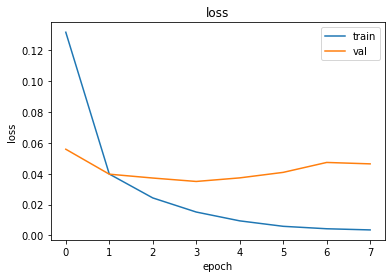

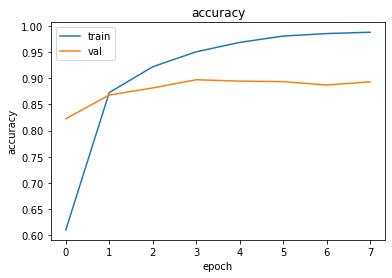

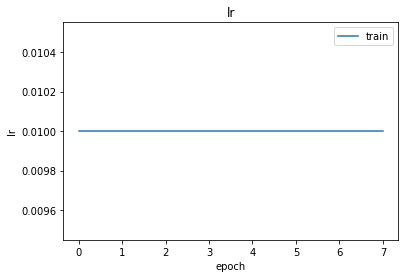

In [45]:
show_history(model_cn_history)

In [49]:
y_cn = produce_pos(model_cn ,x_test)
cn_metrics = compute_metrics(y_cn, y_true)

print("Results obtained with the model:")
for metric_name in cn_metrics.keys():
    print("{0}:\t{1}".format(metric_name, cn_metrics[metric_name]))


21/21 [==============================] - 9s 199ms/step
Results obtained with the model:
accuracy:	0.9065937600514635
macro_f1:	0.7160734303875612


In [50]:
print(classification_report(flat_y_true, flattener(y_cn), zero_division=0))

              precision    recall  f1-score   support

           $       0.99      1.00      1.00       209
          ''       1.00      1.00      1.00        70
           ,       1.00      1.00      1.00       787
       -LRB-       0.68      0.72      0.70        18
       -RRB-       0.59      0.56      0.57        18
           .       1.00      1.00      1.00       638
           :       0.97      1.00      0.98        56
          CC       0.99      1.00      1.00       366
          CD       0.98      0.97      0.97       858
          DT       0.99      0.99      0.99      1335
          EX       1.00      1.00      1.00         5
          IN       0.98      0.96      0.97      1630
          JJ       0.68      0.82      0.75       918
         JJR       0.70      0.56      0.62        59
         JJS       0.92      0.74      0.82        31
          LS       0.00      0.00      0.00         0
          MD       0.98      0.96      0.97       167
          NN       0.86    

As we can notice, the results of the f1-score improved by 1 point in percentage, helping us to produce a better f1-score. Although this may seem a good result, we have to notice how the metric improves mainly because the network now is able to identify predeterminers, differently from the previous networks presented. Despite that, for a lot of classes we reach slightly lower values for the f1-scores <br>

On top of that, we also tried to improve the performances of our model by introducing dropout on both LSTM layers and on the final fully connected layer as stated in [1]. In the paper it is used **Variational dropout** as dropout technique, but for the sake of simplicity we will add the standard dropout present in tensorflow.

Epoch 1/15
123/123 [==============================] - 125s 916ms/step - loss: 0.4782 - accuracy: 0.4738 - val_loss: 0.0667 - val_accuracy: 0.7870 - lr: 0.0100
Epoch 2/15
123/123 [==============================] - 108s 883ms/step - loss: 0.4225 - accuracy: 0.6457 - val_loss: 0.0456 - val_accuracy: 0.8536 - lr: 0.0100
Epoch 3/15
123/123 [==============================] - 110s 894ms/step - loss: 0.4183 - accuracy: 0.6698 - val_loss: 0.0406 - val_accuracy: 0.8675 - lr: 0.0100
Epoch 4/15
123/123 [==============================] - 107s 868ms/step - loss: 0.4129 - accuracy: 0.6845 - val_loss: 0.0361 - val_accuracy: 0.8877 - lr: 0.0100
Epoch 5/15
123/123 [==============================] - 108s 877ms/step - loss: 0.4047 - accuracy: 0.6965 - val_loss: 0.0350 - val_accuracy: 0.8914 - lr: 0.0100
Epoch 6/15
123/123 [==============================] - 107s 869ms/step - loss: 0.4106 - accuracy: 0.6974 - val_loss: 0.0350 - val_accuracy: 0.8902 - lr: 0.0100
Epoch 7/15
123/123 [==========================

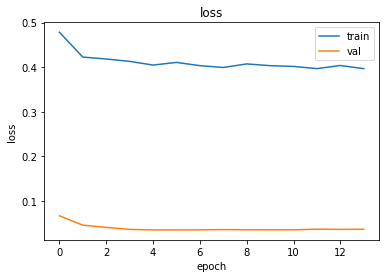

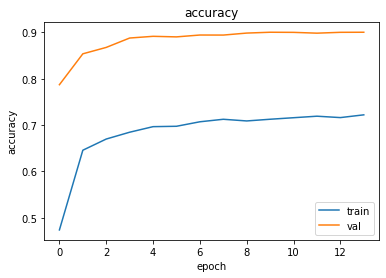

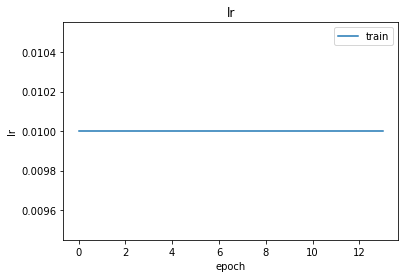

In [68]:
dropout_rate = 0.25
do_model = clipnorm_model(dropout_rate)


do_history =  do_model.fit(x_train, y_train, epochs  = EPOCHS, validation_data= (x_val, y_val), 
                     batch_size = BATCH_SIZE, callbacks = callbacks)

show_history(do_history)

In [69]:
y_dropout = produce_pos(do_model ,x_test)
dropout_metrics = compute_metrics(y_dropout, y_true)

print("Results obtained with the model:")
for metric_name in cn_metrics.keys():
    print("{0}:\t{1}".format(metric_name, dropout_metrics[metric_name]))
    
    
print()
print(classification_report(flat_y_true, flattener(y_dropout), zero_division=0))

21/21 [==============================] - 10s 307ms/step
Results obtained with the model:
accuracy:	0.906207783853329
macro_f1:	0.7198875528220023

              precision    recall  f1-score   support

           $       1.00      1.00      1.00       209
          ''       1.00      1.00      1.00        70
           ,       1.00      1.00      1.00       787
       -LRB-       0.71      0.67      0.69        18
       -RRB-       0.62      0.56      0.59        18
           .       1.00      1.00      1.00       638
           :       1.00      1.00      1.00        56
          CC       0.99      0.99      0.99       366
          CD       0.98      0.97      0.97       858
          DT       0.99      0.99      0.99      1335
          EX       1.00      1.00      1.00         5
          IN       0.98      0.96      0.97      1630
          JJ       0.76      0.75      0.75       918
         JJR       0.83      0.66      0.74        59
         JJS       0.84      0.84      0.8

Also in this case, adding dropout lead to a very tiny increase in performances but this did not seem to produce interesting results, since the improvement is less than 1%. A more detailed look of the effects of dropout for the task can happen adding the dropout layers to the other networks without clip norm and see if there is a better improvement than the one obtained here.

# Conclusions

We can notice from the training done on the two best models, that early stopping intervenes in the training loop of both models we tested while fitting the model on the training data. For this dataset, seems that 10 epochs are sufficient to see good results on the validation sets. <br><br>

We can also notice, from the step of hyperparameter tuning, that all the models reached similar validation scores, in detail the best scores obtained by the models on validation accuracy are:
* 0.8853 for the **baseline model**
* 0.8769 for the **GRU model**
* 0.8954 for the **Double LSTM model**
* 0.8924 for the **Double FC model**

Given the results obtained we can notice that:
* The GRU model did not have worst performance than the rest of the models as concerns validation accuracy, despite having less expressive capacity than the rest of the models which use LSTM cells. 
* Increasing the dimension of the model did not produce big improvements on the results obtained as well. Despite we saw some changes in the validation scores, this change in results may be harmful in situations in which saving computational costs would be beneficial.

Despite what said in the second point, we still decided to evaluate the two best models (i.e. model 3 and 4) on the test set. Here the models performed well, showing that the network actually learned how to generalize on unseen data. As before, also in this case the results obtained with the Double LSTM models are slightly better in percentage than the results obtained by the Double FC models, both in accuracy and in f1-score, as shown in this table:

|             | Accuracy | F1-Score |
|:-----------:|----------|----------|
| Double LSTM | 0.9038   | 0.7004   |
|  Double FC  | 0.8990   | 0.6993   |

The main sources of errors arised from categories with a very low support in both cases and from part of speech very similar among them (proper nouns and nouns, singular and plural proper nouns, comparatives adjectives and adverbs), so in our opinion a possible solution would be performing some kind of data augmentation or weight sampling techniques to give more importance to classes with a lower support and make the network distinghuish them, but we leave that to a future work. 

We also noticed from the experiments run that the introduction of clip_norm and dropout helps the model recognizing some tags which have low support in the dataset (as happened for predeterminers), thus producing an higher f1-score. <br><br>
A future work in this field would be the one of fitting those models on bigger datasets, in which also less frequent tags have a higher support, in order to see the limitations of those small model's capacity. Other possible works can be related to the use of larger models to inspect the differences with respect to these simple models in terms of f1-scores. 

# References

* [1] Nils Reimers and Iryna Gurevych (2017).<br> **Optimal Hyperparameters for Deep LSTM-Networks for Sequence Labeling Tasks.** <br> CoRR journal, abs/1707.06799 volume.